# Importing Necessary Packages

In [1]:
import requests
from bs4 import BeautifulSoup
import re

import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from statistics import mean

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

import os
import base64
import io
import matplotlib.pyplot as plt

import joblib

from flask import Flask, render_template, request

# Data Acquisition

Sales Report database is gathered from Kaggle

In [2]:
"""https://www.kaggle.com/datasets/shivashi11/food-demand-prediction"""

'https://www.kaggle.com/datasets/shivashi11/food-demand-prediction'

In [3]:
saleDf = pd.read_csv(r"..\DataSet\Dish Sales dataset\sales_info.csv")
saleDf

id  Week  Center Id  Dish Id  Checkout Price  Base Price   
0       1379560     1         55     1885          136.83      152.29  \
1       1466964     1         55     1993          136.83      135.83   
2       1346989     1         55     2539          134.86      135.86   
3       1338232     1         55     2139          339.50      437.53   
4       1448490     1         55     2631          243.50      242.50   
...         ...   ...        ...      ...             ...         ...   
456543  1271326   145         61     1543          484.09      484.09   
456544  1062036   145         61     2304          482.09      482.09   
456545  1110849   145         61     2664          237.68      321.07   
456546  1147725   145         61     2569          243.50      313.34   
456547  1361984   145         61     2490          292.03      290.03   

        Emailer For Promotion  Homepage Featured  Num Orders  
0                           0                  0         177  
1                           0                  0         270  
2                           0                  0         189  
3                           0                  0          54  
4                           0                  0          40  
...                       ...                ...         ...  
456543                      0                  0          68  
456544                      0                  0          42  
456545                      0                  0         501  
456546                      0                  0         729  
456547                      0                  0         162  

[456548 rows x 9 columns]

In [4]:
dishDf = pd.read_csv(r"..\DataSet\Dish Sales dataset\meal_info.csv")
dishDf

Dish Id      Category      Cuisine  Recipe Id
0      1885     Beverages         Thai       2614
1      1993     Beverages         Thai       4690
2      2539     Beverages         Thai      12872
3      1248     Beverages       Indian      12904
4      2631     Beverages       Indian       2620
5      1311        Extras         Thai       3878
6      1062     Beverages      Italian      94044
7      1778     Beverages      Italian     105325
8      1803        Extras         Thai      13117
9      1198        Extras         Thai      13116
10     2707     Beverages      Italian      12907
11     1847          Soup         Thai       3883
12     1438          Soup         Thai       5162
13     2494          Soup         Thai       8164
14     2760  Other Snacks         Thai      10122
15     2490         Salad      Italian       3925
16     1109     Rice Bowl       Indian       4008
17     2290     Rice Bowl       Indian      12895
18     1525  Other Snacks         Thai     104811
19     2704  Other Snacks         Thai       5127
20     1878      Starters         Thai      12897
21     2640      Starters         Thai      10145
22     2577      Starters         Thai      10147
23     1754      Sandwich      Italian       3862
24     1971      Sandwich      Italian      47498
25     2306         Pasta      Italian       3910
26     2139     Beverages       Indian      68358
27     2826      Sandwich      Italian       4705
28     2664         Salad      Italian     100036
29     2569         Salad      Italian      10149
30     1230     Beverages  Continental       5163
31     1207     Beverages  Continental      87347
32     2322     Beverages  Continental     147045
33     2492        Desert       Indian       4158
34     1216         Pasta      Italian       3863
35     1727     Rice Bowl       Indian       3882
36     1902       Biryani       Indian     105291
37     1247       Biryani       Indian      76669
38     2304        Desert       Indian       3869
39     1543        Desert       Indian      10136
40     1770       Biryani       Indian      12891
41     2126         Pasta      Italian     100021
42     1558         Pizza  Continental      12867
43     2581         Pizza  Continental       3935
44     1962         Pizza  Continental     105320
45     1571          Fish  Continental      12894
46     2956          Fish  Continental      12868
47     2104          Fish  Continental      47497
48     2444       Seafood  Continental       3881
49     2867       Seafood  Continental      12869
50     1445       Seafood  Continental      12871

In [5]:
centerDf = pd.read_csv(r"..\DataSet\Dish Sales dataset\fulfilment_center_info.csv")
centerDf

Center Id  City Code  Region Code Center Type  Op Area
0          11        679           56      TYPE_A      3.7
1          13        590           56      TYPE_B      6.7
2         124        590           56      TYPE_C      4.0
3          66        648           34      TYPE_A      4.1
4          94        632           34      TYPE_C      3.6
..        ...        ...          ...         ...      ...
72         53        590           56      TYPE_A      3.8
73         30        604           56      TYPE_A      3.5
74         76        614           85      TYPE_A      3.0
75         68        676           34      TYPE_B      4.1
76         51        638           56      TYPE_A      7.0

[77 rows x 5 columns]

Dish Ingredient database is downloaded from RecipeDB website

In [6]:
"""https://cosylab.iiitd.edu.in/recipedb/"""

'https://cosylab.iiitd.edu.in/recipedb/'

Web Scrapping code to get Dish ingredient

In [7]:
r = pd.read_csv(r"..\DataSet\Dish Sales dataset\meal_info.csv")

In [8]:
def convert_to_float(frac_str):
    num = " "
    denom = 1
    whole = 0
    if re.findall("[a-zA-Z]", frac_str) or None or "":
        return 0
    else:
        try:
            return float(frac_str)
        except ValueError:
            try: 
                num, denom = frac_str.split('/')
            except ValueError:
                num = frac_str
            try:
                leading, num = num.split(' ')
                whole = float(leading)
            except ValueError:
                whole = 0
            num = num if re.findall("[0-9]",num) else 0 
            frac = float(num) / float(denom)
            return whole - frac if whole < 0 else whole + frac


Scarping Code

In [9]:
recipeId = list(r["Recipe Id"])
d_ings = []
d_names = []
data = []
print("Dishes we are using in this model")
for num, i in enumerate(recipeId):
    url = "https://cosylab.iiitd.edu.in/recipedb/search_recipeInfo/{0}".format(i)
    
    response = requests.get(url)

    soup = BeautifulSoup(response.text, 'html.parser')

    rows = soup.find('table', {'id':'myTable'}).find('tbody').find_all('tr')
    dish_name = soup.find('div', {'class':'col s12 m12'}).find('h3').text

    print(num + 1, dish_name, i)
    for row in rows:
        dict = {}
    
        dict["Recipe Id"] = i
        dict["Ingredient Name"] =  row.find_all('td')[0].text
        dict["Dish Name"] =  dish_name
        quantity = row.find_all('td')[1].text
        dict["Quantity"] = convert_to_float(quantity)
        unit = row.find_all('td')[2].text
        if unit == "":
            dict["Unit"] =  unit
        elif unit[len(unit)-1] == "s":
            dict["Unit"] =  unit[:len(unit) - 1]
        else:
            dict["Unit"] =  unit
        
        data.append(dict)


    
all_recipe = pd.DataFrame(data)

all_recipe.to_csv(r"..\DataSet\Dish dataset\rawData.csv", index = False)

Dishes we are using in this model
1 Dukkah 2614
2 Spicy Beef Bulgogi 4690
3 Speculaas Cookies or Spicy Sinterklass Cakes 12872
4 Kletskopjes 12904
5 Egyptian Wheat Porridge (Belila) 2620
6 Buchi 3878
7 Tequeños 94044
8 Hungarian Sponge Cake (Piskota Torta) 105325
9 German Pancakes I 13117
10 Anna's German Dumplings 13116
11 Dutch Boterkoek 12907
12 Maja Blanca (Coconut Pudding) 3883
13 Basic Truffles 5162
14 Boscobel Beach Ginger Cake 8164
15 Roesti 10122
16 Pan de Sal - Filipino Bread Rolls 3925
17 Coconut Curried Tofu with Green Beans and Coconut Rice 4008
18 Smoky Gouda Cheese Dip 12895
19 English Monkey (Breakfast Snack) 104811
20 Besan Ladoo 5127
21 Speculaas 12897
22 Portuguese Burnt Sugar Candy 10145
23 Espiros 10147
24 Chocolate-Orange Rice Pudding 3862
25 Sambusa Pastry 47498
26 Chinky's Puto Bread 3910
27 Agni Beverage 68358
28 Mom's Kimchi Egg 4705
29 Heirloom Brown Sugar Cookies 100036
30 Portuguese Sweet Bread II 10149
31 Zucchini Tomato Pie 5163
32 Champurrado (Mexican Ch

In [10]:
all_recipe = pd.read_csv(r"..\DataSet\Dish dataset\rawData.csv")
all_recipe

Recipe Id Ingredient Name               Dish Name  Quantity        Unit
0         2614        hazelnut                  Dukkah  0.666667         cup
1         2614     sesame seed                  Dukkah  0.500000         cup
2         2614  coriander seed                  Dukkah  2.000000  tablespoon
3         2614      cumin seed                  Dukkah  2.000000  tablespoon
4         2614    black pepper                  Dukkah  2.000000  tablespoon
..         ...             ...                     ...       ...         ...
338      12871     brown sugar  Dutch Almond Boterkoek  1.250000         cup
339      12871   purpose flour  Dutch Almond Boterkoek  2.000000         cup
340      12871  almond extract  Dutch Almond Boterkoek  1.000000    teaspoon
341      12871             egg  Dutch Almond Boterkoek  1.000000         NaN
342      12871          almond  Dutch Almond Boterkoek  0.500000         cup

[343 rows x 5 columns]

Cooking Measurement is taken from these website

In [11]:
"""https://www.aqua-calc.com/calculate/food-volume-to-weight"""

'https://www.aqua-calc.com/calculate/food-volume-to-weight'

In [12]:
"""https://www.thecalculatorsite.com/cooking/cooking-calculator.php"""

'https://www.thecalculatorsite.com/cooking/cooking-calculator.php'

In [13]:
vMeasure = pd.read_csv(r"..\Database\vMeasurement.csv")
vMeasure

Ingredient Name  Quantity        Unit  Equivalent Quantity C_unit
0      active yeast         1    teaspoon                 4.75      g
1       adzuki bean         1         cup               208.17      g
2            almond         1         cup                98.37      g
3            almond         1  tablespoon                 5.90      g
4    almond extract         1    teaspoon                 5.00     mL
..              ...       ...         ...                  ...    ...
142     wheat flour         1         cup               119.50      g
143      white rice         1         cup               124.69      g
144     white sugar         1         cup               202.88      g
145     white sugar         1  tablespoon                12.70      g
146        zucchini         1         cup                70.38      g

[147 rows x 5 columns]

# Preprocessing

preprocessing of Recipe Dataset

In [14]:
r = pd.read_csv(r"..\DataSet\Dish Sales dataset\meal_info.csv")
all_recipe = pd.read_csv(r"..\DataSet\Dish dataset\rawData.csv")

In [15]:
dict = {
    'Recipe Id' : r["Recipe Id"],
    'Dish Id' : r["Dish Id"]
} 

In [16]:
dd = pd.DataFrame(dict)

In [17]:
dd = dd.merge(all_recipe, left_on='Recipe Id', right_on='Recipe Id', how= "left")
dd = dd.sort_values(by = ['Ingredient Name', 'Unit'])
dd.to_csv(r"..\DataSet\Dish dataset\allRecipe.csv", index = False)

In [18]:
ar = pd.read_csv(r"..\DataSet\Dish dataset\allRecipe.csv")
ar = ar.sort_values(by = ['Ingredient Name', 'Unit'])
ar

Recipe Id  Dish Id Ingredient Name   
0         3925     2490    active yeast  \
1        10149     2569    active yeast   
2        47497     2104     adzuki bean   
3        12872     2539          almond   
4        12904     1248          almond   
..         ...      ...             ...   
338       4690     1993     white sugar   
339       3878     1311     white sugar   
340      13117     1803     white sugar   
341      12868     2956     white sugar   
342       5163     1230        zucchini   

                                        Dish Name  Quantity        Unit  
0               Pan de Sal - Filipino Bread Rolls       2.5    teaspoon  
1                       Portuguese Sweet Bread II       2.5    teaspoon  
2                           Somalian Adzuki Beans       0.5         cup  
3    Speculaas Cookies or Spicy Sinterklass Cakes       0.5         cup  
4                                     Kletskopjes       0.5         cup  
..                                            ...       ...         ...  
338                            Spicy Beef Bulgogi       2.5  tablespoon  
339                                         Buchi       2.0  tablespoon  
340                             German Pancakes I       2.0  tablespoon  
341                       Botercake (Butter Cake)       1.0  tablespoon  
342                           Zucchini Tomato Pie       2.0         cup  

[343 rows x 6 columns]

In [19]:
ar.isnull().sum()

Recipe Id           0
Dish Id             0
Ingredient Name     0
Dish Name           0
Quantity            0
Unit               20
dtype: int64

In [20]:
ar[ar["Unit"].isna()]

Recipe Id  Dish Id Ingredient Name   
127      94044     1062             egg  \
128     105325     1778             egg   
129      13117     1803             egg   
130      13116     1198             egg   
131       8164     2494             egg   
132       3925     2490             egg   
133     104811     1525             egg   
134      12897     1878             egg   
135      10147     2577             egg   
136       3910     2306             egg   
137       4705     2826             egg   
138     100036     2664             egg   
139      10149     2569             egg   
140       5163     1230             egg   
141       3882     1727             egg   
142      76669     1247             egg   
143      12867     1558             egg   
144      12894     1571             egg   
145      12868     2956             egg   
146      12871     1445             egg   

                                 Dish Name  Quantity Unit  
127                               Tequeños       2.0  NaN  
128  Hungarian Sponge Cake (Piskota Torta)       8.0  NaN  
129                      German Pancakes I       3.0  NaN  
130                Anna's German Dumplings       3.0  NaN  
131             Boscobel Beach Ginger Cake       4.0  NaN  
132      Pan de Sal - Filipino Bread Rolls       2.0  NaN  
133       English Monkey (Breakfast Snack)       1.0  NaN  
134                              Speculaas       1.0  NaN  
135                                Espiros      12.0  NaN  
136                    Chinky's Puto Bread       2.0  NaN  
137                       Mom's Kimchi Egg       2.0  NaN  
138           Heirloom Brown Sugar Cookies       3.0  NaN  
139              Portuguese Sweet Bread II       2.0  NaN  
140                    Zucchini Tomato Pie       3.0  NaN  
141              Philippine Butter Cookies       3.0  NaN  
142           Scroggins Biscuits (Cookies)       2.0  NaN  
143                      Holland Boterkoek       1.0  NaN  
144                   Dutch Letter Cookies       1.0  NaN  
145                Botercake (Butter Cake)       5.0  NaN  
146                 Dutch Almond Boterkoek       1.0  NaN

In [21]:
uniqueUnits= ar["Unit"].unique()
uniqueUnits

array(['teaspoon', 'cup', 'tablespoon', 'ounce', 'quart', nan, 'pound'],
      dtype=object)

In [22]:
for i in ar[ar["Ingredient Name"] == "egg"].index:
    ar.loc[i, 'Unit'] = ar.loc[i, 'Quantity']

In [23]:
ar[ar["Unit"].isna()]

Empty DataFrame
Columns: [Recipe Id, Dish Id, Ingredient Name, Dish Name, Quantity, Unit]
Index: []

In [24]:
ar.to_csv(r"..\Database\allRecipe.csv", index = False)

Creating Empty Inventory

In [25]:
inventory = ar.drop(['Recipe Id','Dish Id','Dish Name'], axis = 1)
inventory["Quantity"] = inventory["Quantity"].replace(list(inventory["Quantity"]), 0)
inventory = inventory.drop_duplicates()
inventory = inventory.sort_values(by = ['Ingredient Name', 'Unit'])
inventory.to_csv(r"..\Database\inventory.csv", index = False)

preprocessing of Historical sales dataset

In [26]:
le = LabelEncoder()
encData = {}
sales = saleDf.merge(centerDf, left_on='Center Id', right_on='Center Id', how= "left")
sales = sales.merge(dishDf, left_on='Dish Id', right_on='Dish Id', how= "left")
col = ["Category", "Cuisine","Center Type"]
for column in col:
    enc = sales[column].unique()
    enc1 = list(set(le.fit_transform(sales[column])))
    for name, data in zip(enc,enc1):
        encData[name] = data

In [27]:
def preprocessModule1(df):
    
    df['Week'] = df['Week'].astype('int64')
    df['Center Id'] = df['Center Id'].astype('int64')
    df['Dish Id'] = df['Dish Id'].astype('int64')
    df['Checkout Price'] = df['Checkout Price'].astype('float64')
    df['Base Price'] = df['Base Price'].astype('float64')
    df['Emailer For Promotion'] = df['Emailer For Promotion'].astype('int64')
    df['Homepage Featured'] = df['Homepage Featured'].astype('int64')

    #Remove unnecessary fields
    if "id" in list(df.columns):
        df = df.drop(['id'], axis=1) 
        

    #Merging of dataframes
    df = df.merge(dishDf, left_on='Dish Id', right_on='Dish Id', how= "left")
    df = df.merge(centerDf, left_on='Center Id', right_on='Center Id', how= "left")

    #Encoding the record
    for name, data in encData.items():
        df = df.replace(name,data)

        
    return df

In [28]:
def preprocessSTL(df):
    
    tempData = df
    
    sStl = data_stl.drop(['Num Orders'], axis = 1)
    
    tempData["Trend"] = np.nan
    tempData["Seasonal"] = np.nan
    tempData["Residual"] = np.nan
    
    tempData = pd.concat([sStl, tempData], axis = 0)
    
    tempData = performImputation(tempData)
    
    return tempData.tail(len(df))

In [29]:
def stlDecomposition(data, target_column, period):
    
    result = seasonal_decompose(data[target_column], model='additive', period = period)

    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    data_stl = pd.concat([trend, seasonal, residual], axis=1)
    data_stl.columns = ["Trend", "Seasonal", "Residual"]
    data_stl = pd.concat([data, data_stl], axis=1)

    return data_stl

In [30]:
def performImputation(X):
    
    imputer = IterativeImputer(estimator= HistGradientBoostingRegressor(max_iter=100, max_depth=5, min_samples_leaf=5))
    X_filled = imputer.fit_transform(X)
    X_imputed = pd.DataFrame(X_filled, columns = X.columns)

    return X_imputed

# Model Training

In [31]:
def fitModel(model, X_train, y_train):
    
    return model.fit(X_train, y_train)

In [32]:
def trainModel(X_train, Y_train):
    
    gb = fitModel(GradientBoostingRegressor(n_estimators=100,
                                            max_depth=5,
                                            min_samples_leaf=5,
                                            learning_rate=0.1),
                  X_train,
                  Y_train)
    hgb = fitModel(HistGradientBoostingRegressor(max_iter=100,
                                                 max_depth=5,
                                                 min_samples_leaf=5),
                   X_train,
                   Y_train)
    rf = fitModel(RandomForestRegressor(n_estimators=100,
                                        max_depth=5,
                                        min_samples_leaf=5),
                  X_train,
                  Y_train)
    
    return gb, hgb, rf

In [33]:
saleDf = preprocessModule1(saleDf)
saleDf.to_csv(r"..\Database\mainData.csv", index= False)
saleDf

Week  Center Id  Dish Id  Checkout Price  Base Price   
0          1         55     1885          136.83      152.29  \
1          1         55     1993          136.83      135.83   
2          1         55     2539          134.86      135.86   
3          1         55     2139          339.50      437.53   
4          1         55     2631          243.50      242.50   
...      ...        ...      ...             ...         ...   
456543   145         61     1543          484.09      484.09   
456544   145         61     2304          482.09      482.09   
456545   145         61     2664          237.68      321.07   
456546   145         61     2569          243.50      313.34   
456547   145         61     2490          292.03      290.03   

        Emailer For Promotion  Homepage Featured  Num Orders  Category   
0                           0                  0         177         0  \
1                           0                  0         270         0   
2                           0                  0         189         0   
3                           0                  0          54         0   
4                           0                  0          40         0   
...                       ...                ...         ...       ...   
456543                      0                  0          68        10   
456544                      0                  0          42        10   
456545                      0                  0         501        12   
456546                      0                  0         729        12   
456547                      0                  0         162        12   

        Cuisine  Recipe Id  City Code  Region Code  Center Type  Op Area  
0             0       2614        647           56            0      2.0  
1             0       4690        647           56            0      2.0  
2             0      12872        647           56            0      2.0  
3             1      68358        647           56            0      2.0  
4             1       2620        647           56            0      2.0  
...         ...        ...        ...          ...          ...      ...  
456543        1      10136        473           77            2      4.5  
456544        1       3869        473           77            2      4.5  
456545        2     100036        473           77            2      4.5  
456546        2      10149        473           77            2      4.5  
456547        2       3925        473           77            2      4.5  

[456548 rows x 15 columns]

In [34]:
data = pd.read_csv("..\Database\mainData.csv")

In [35]:
data_stl = stlDecomposition(data, "Num Orders", period=7)
X = data_stl.drop("Num Orders", axis=1)
Y = data_stl["Num Orders"]
X_imputed = performImputation(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42, shuffle=False)
gb, hgb, rf = trainModel(X_train, Y_train)

In [36]:
def storePKL(gb, hgb, rf):
    pkl_dir = os.path.abspath('PKL')
    
    if not os.path.exists(pkl_dir):
        os.makedirs(pkl_dir)

    gb_path = os.path.join(pkl_dir, 'gb.pkl')
    hgb_path = os.path.join(pkl_dir, 'hgb.pkl')
    rf_path = os.path.join(pkl_dir, 'rf.pkl')

    joblib.dump(gb, gb_path)
    joblib.dump(hgb, hgb_path)
    joblib.dump(rf, rf_path)

In [37]:
storePKL(gb, hgb, rf)

In [38]:
def getModel(model_name):
    
    pkl_dir = os.path.abspath('PKL')
    model_path = ""
    
    if model_name == "gradient_boosting":
        model_path = os.path.join(pkl_dir, 'gb.pkl')
    elif model_name == "random_forest":
        model_path = os.path.join(pkl_dir, 'rf.pkl')
    elif model_name == "hist_gradient_boosting":
        model_path = os.path.join(pkl_dir, 'hgb.pkl')
    else:
        print(f"Invalid model name: {model_name}")

    model = joblib.load(model_path)
    #model = joblib.load('hgb.pkl')

    return model

In [39]:
def runModel(model_name, X_test):

    model = getModel(model_name)
    Y_pred = model.predict(X_test)
    
    return model, Y_pred

In [40]:
import time
def timeTaken(model_name, X_test):
    start_time = time.time()
    
    model, Y_pred = runModel(model_name, X_test)
    
    r2 = r2_score(Y_test, Y_pred)
    print("R-squared score:", r2)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Time consumed by the ",model," Model is :" ,elapsed_time, "seconds")

In [41]:
timeTaken('gradient_boosting', X_test)

R-squared score: 0.9985974502189606
Time consumed by the  GradientBoostingRegressor(max_depth=5, min_samples_leaf=5)  Model is : 0.14933514595031738 seconds


In [42]:
def modelSummary(model, X_test, Y_test):
    
    r2 = model.score(X_test, Y_test)
    
    Y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(Y_test, Y_pred)
    
    mse = mean_squared_error(Y_test, Y_pred)
    
    rmse = mse**0.5
    
    print("Model : ",model,"\nMAE : ", mae,"\nMSE :", mse,"\nRMSE :",rmse,"\nr2 score :",r2 , "\nAccuaracy :", r2*100,"%")

In [43]:
modelSummary(getModel("hist_gradient_boosting"), X_test, Y_test)

Model :  HistGradientBoostingRegressor(max_depth=5, min_samples_leaf=5) 
MAE :  10.054091855485366 
MSE : 4004.5093373705145 
RMSE : 63.281192603889146 
r2 score : 0.9701097711263219 
Accuaracy : 97.01097711263219 %


In [44]:
modelSummary(getModel("random_forest"), X_test, Y_test)

Model :  RandomForestRegressor(max_depth=5, min_samples_leaf=5) 
MAE :  47.275079147348585 
MSE : 4559.036662062005 
RMSE : 67.5206387859446 
r2 score : 0.9659707000803244 
Accuaracy : 96.59707000803243 %


In [45]:
modelSummary(getModel("gradient_boosting"), X_test, Y_test)

Model :  GradientBoostingRegressor(max_depth=5, min_samples_leaf=5) 
MAE :  8.42129320612067 
MSE : 187.90500795546242 
RMSE : 13.707844759679125 
r2 score : 0.9985974502189606 
Accuaracy : 99.85974502189606 %


In [46]:
center_id = saleDf['Center Id'].unique()
center_id = np.sort(center_id)
center_id = list(center_id)

In [47]:
dish_id = saleDf['Dish Id'].unique()
dish_id = np.sort(dish_id)
dish_id = list(dish_id)

In [48]:
def createGraphFolder(folder_names):
    current_dir = os.getcwd()
    graph_dir = os.path.join(current_dir, 'graph')
    
    if not os.path.exists(graph_dir):
        os.makedirs(graph_dir)
    
    for name in folder_names:
        folder_path = os.path.join(graph_dir, name)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)


In [49]:
folder_names = ['HGB STL', 'GB STL', 'RF STL']

In [50]:
createGraphFolder(folder_names)

In [51]:
def saveGraph(dish_id, graph_path, img_string):
    img_data = base64.b64decode(img_string)
    
    with open(graph_path, 'wb') as f:
        f.write(img_data)
    
    img = plt.imread(graph_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [52]:
def generateAndSaveGraphs(folder_name, model, X_test, Y_test, dish_id):
    graph_dir = os.path.join('graph', folder_name)
    if not os.path.exists(graph_dir):
        os.makedirs(graph_dir)

    if 'Num Orders' in X_test.columns:
        X_test = X_test.drop(['Num Orders'], axis=1)

    if 'Y_pred' in X_test.columns:
        X_test = X_test.drop(['Y_pred'], axis=1)

    Y_pred = model.predict(X_test)

    df1 = X_test.copy()
    df1["Y_pred"] = Y_pred

    df2 = X_test.copy()
    df2["Num Orders"] = Y_test

    for i in dish_id:
        tempD1 = df1[df1["Dish Id"] == i]
        tempD2 = df2[df2["Dish Id"] == i]

        tempD1 = tempD1.groupby("Week").sum()
        tempD2 = tempD2.groupby("Week").sum()

        plt.figure(figsize=(10, 6))
        plt.plot(tempD2["Num Orders"].index, tempD2["Num Orders"], label='Actual Orders')
        plt.plot(tempD1["Y_pred"].index, tempD1["Y_pred"], label='Predicted Orders')

        plt.xlabel('weeks')
        plt.ylabel('Number of Orders for all Restaurants')
        plt.title(f'Actual vs Predicted Number of Orders sold per Week for Dish id: {i}')
        plt.legend()

        img_buffer = io.BytesIO()
        plt.savefig(img_buffer, format='png')
        img_buffer.seek(0)
        img_string = base64.b64encode(img_buffer.getvalue()).decode()
        plt.close()

        graph_path = os.path.join(graph_dir, f'{i}.png')
        saveGraph(i, graph_path, img_string)


In [53]:
folderList = [("HGB STL", getModel("hist_gradient_boosting")),
              ("GB STL", getModel("gradient_boosting")),
              ("RF STL",getModel("random_forest"))]

Graph generated using the  HistGradientBoostingRegressor(max_depth=5, min_samples_leaf=5)


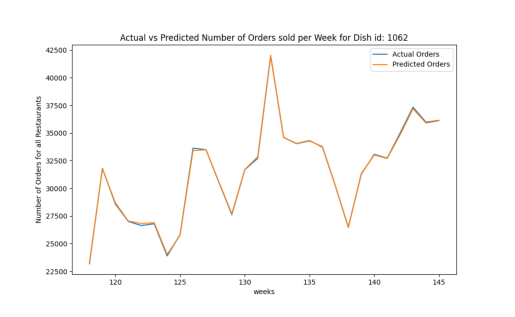

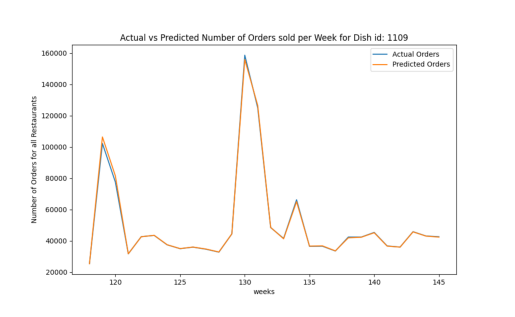

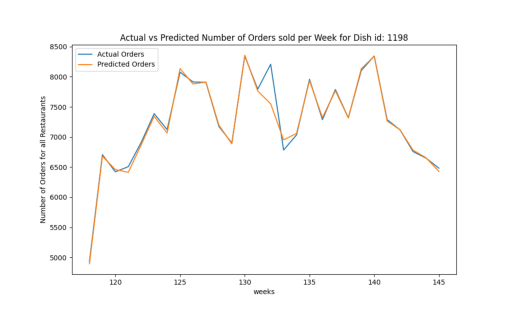

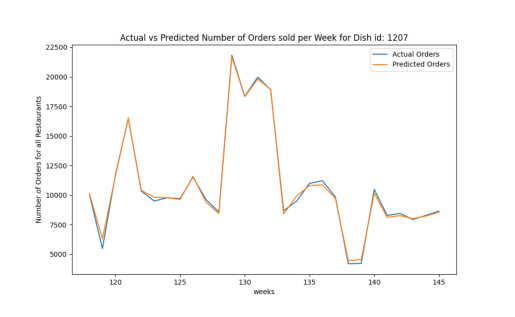

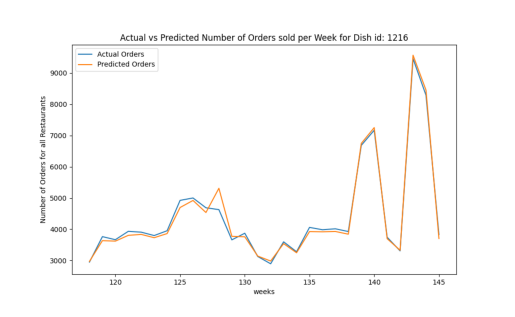

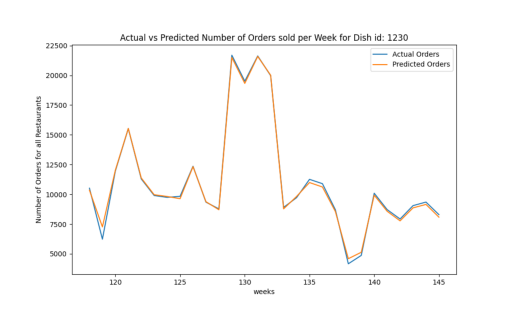

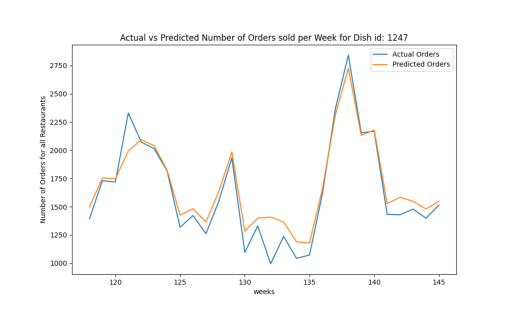

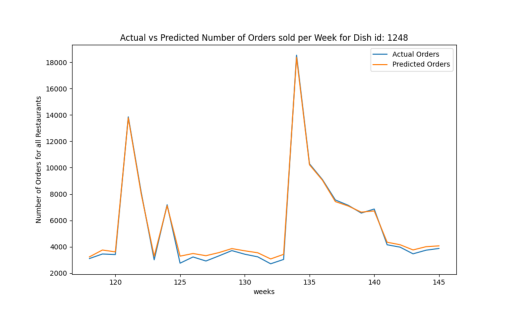

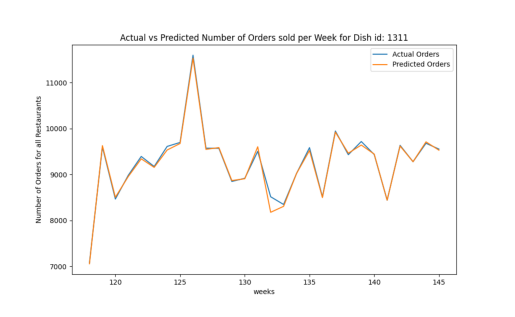

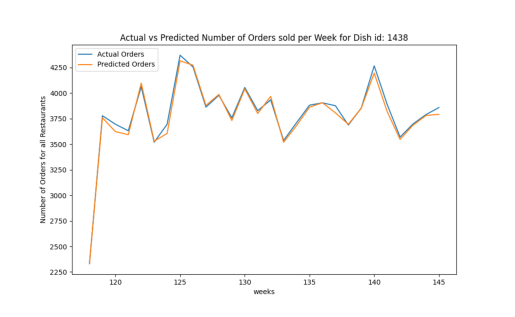

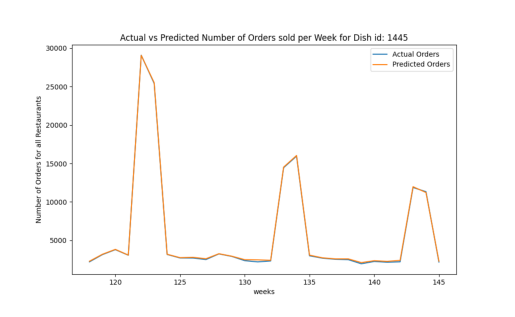

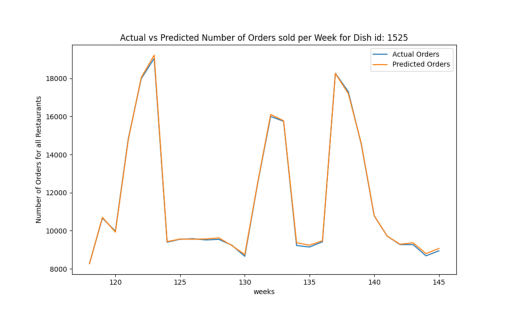

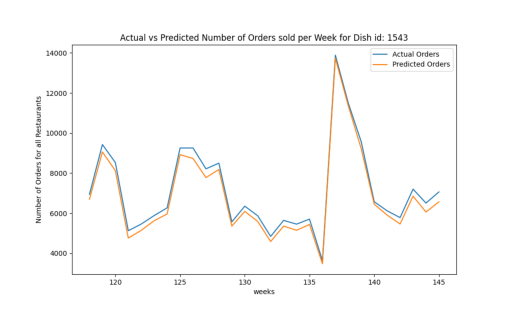

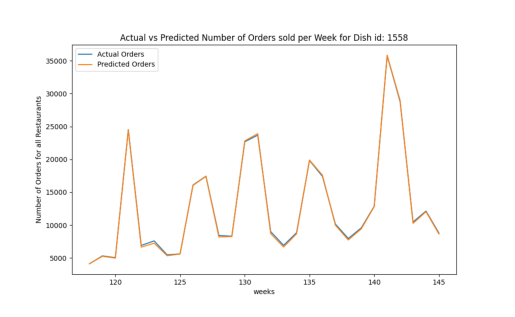

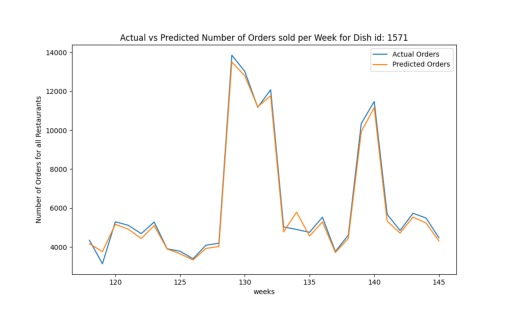

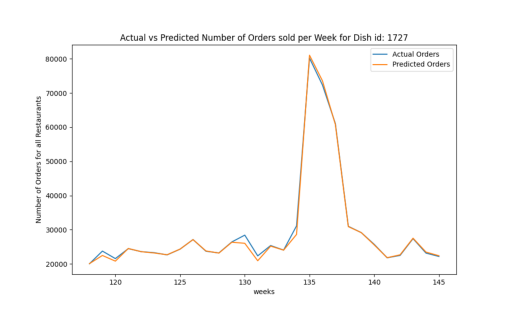

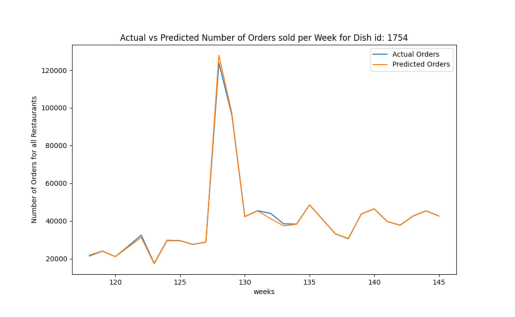

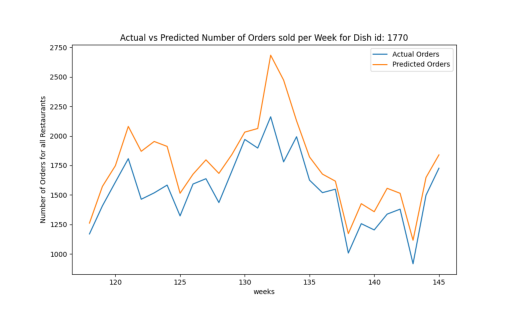

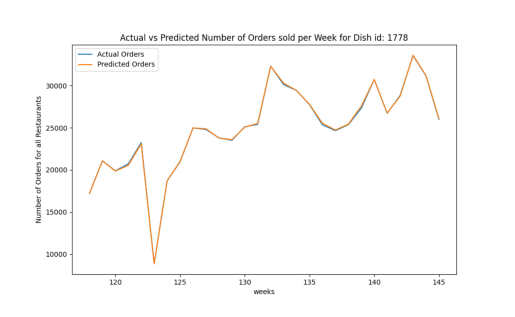

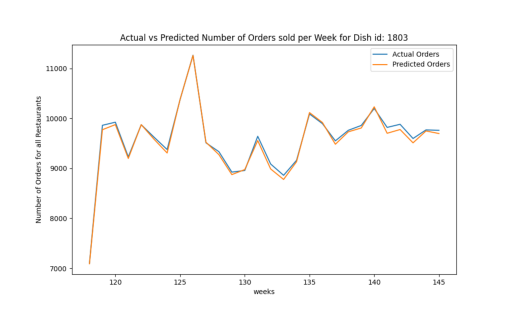

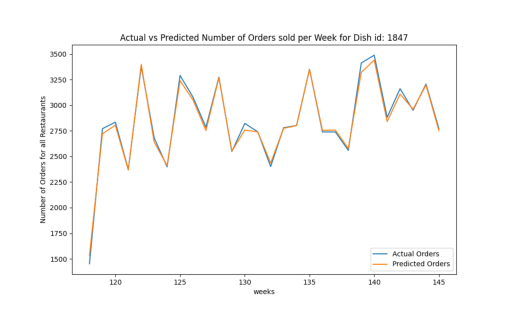

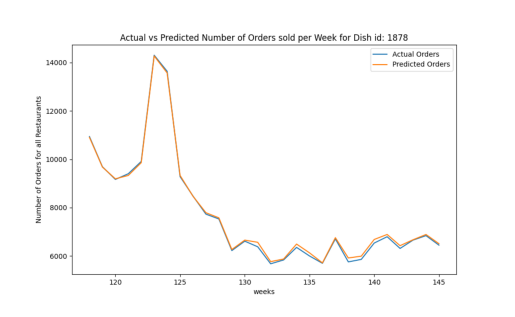

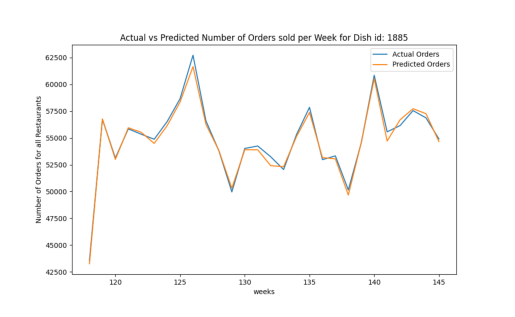

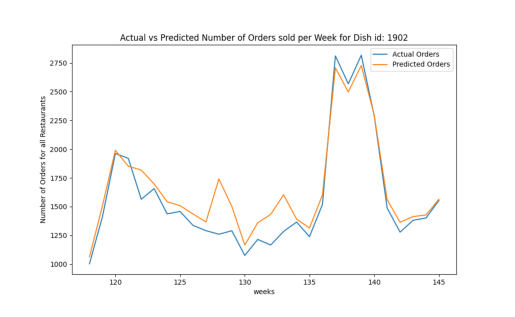

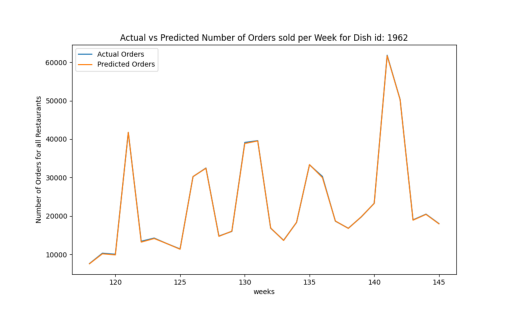

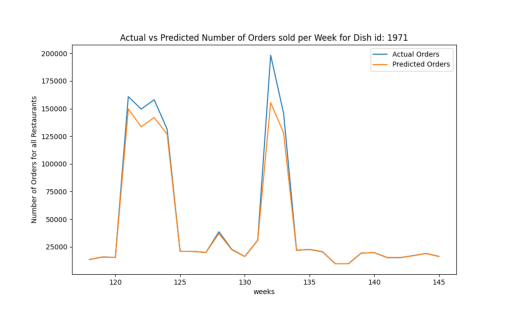

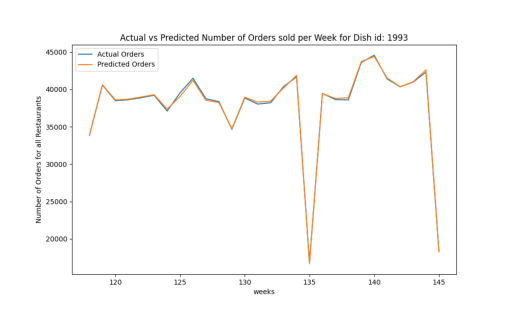

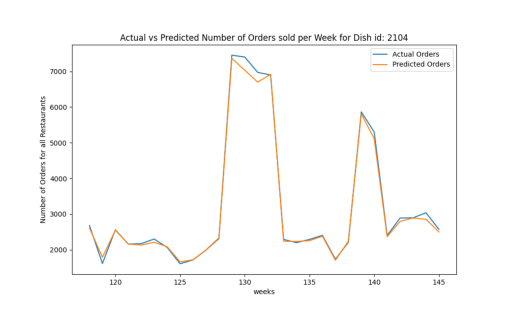

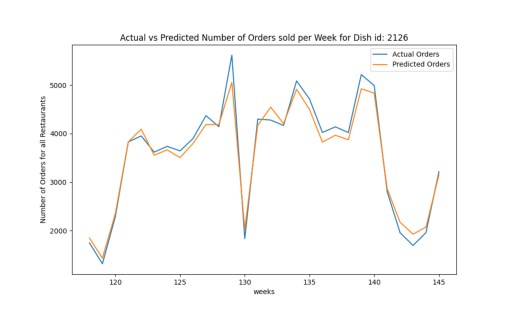

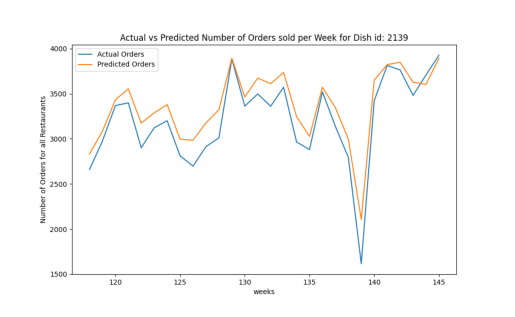

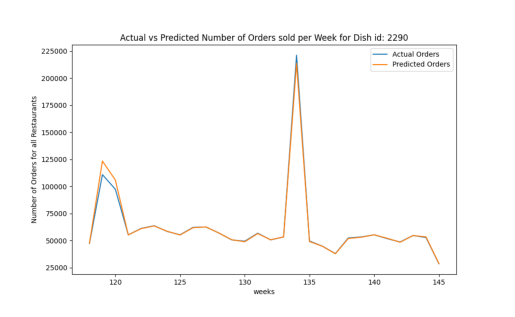

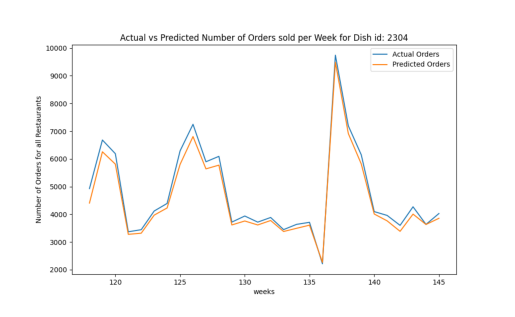

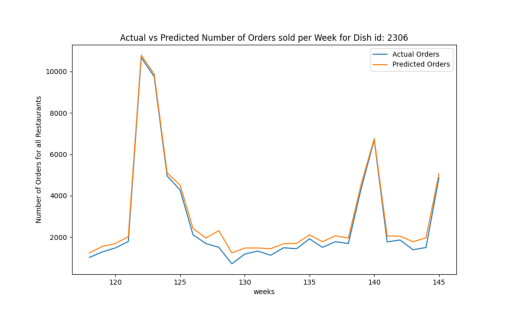

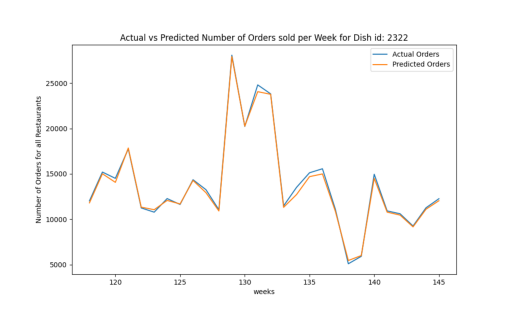

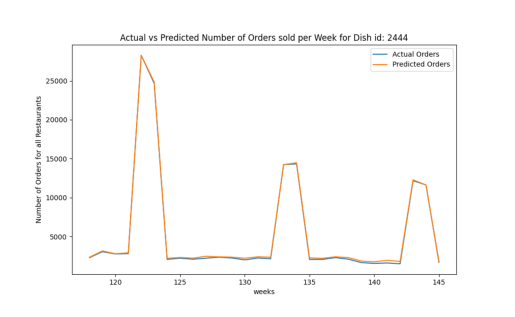

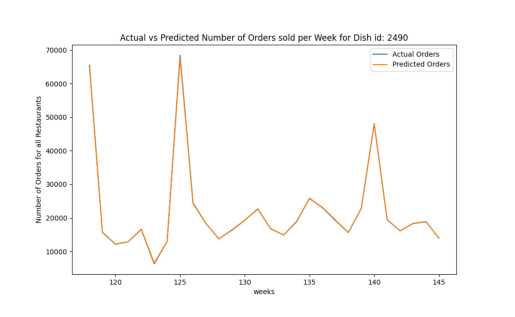

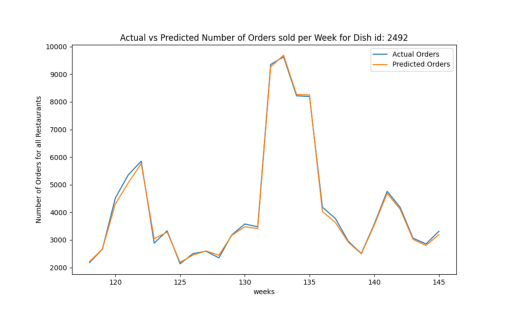

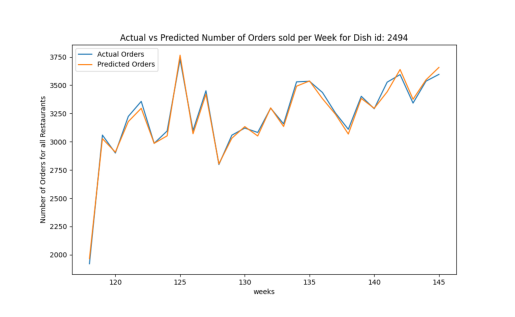

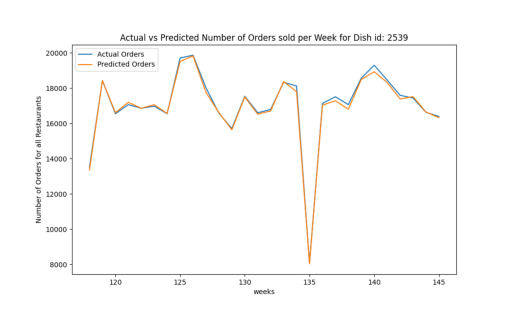

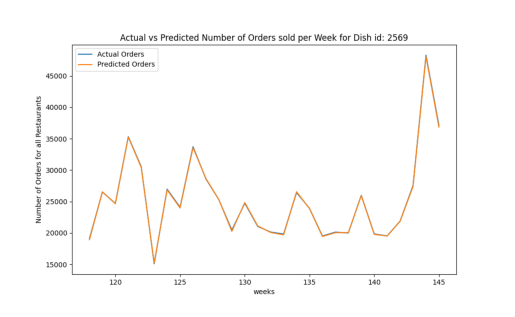

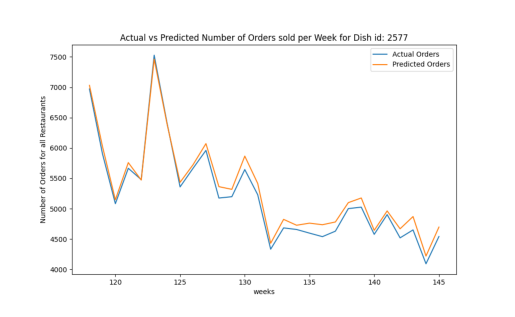

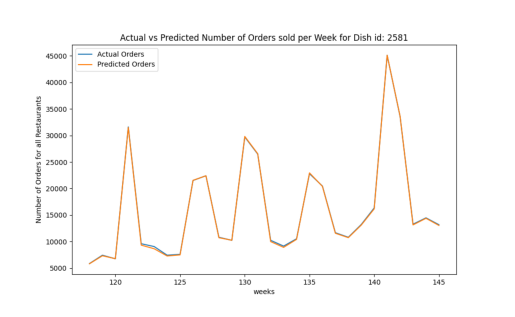

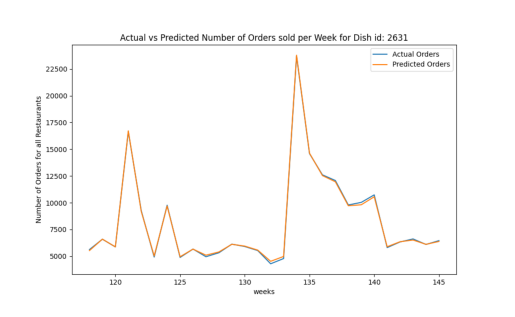

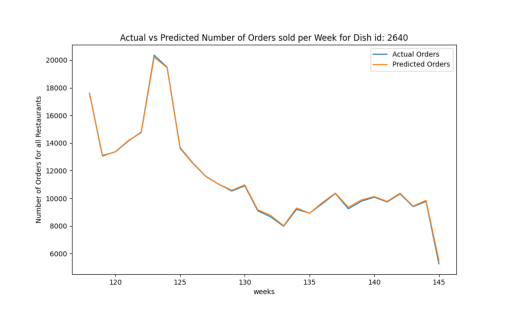

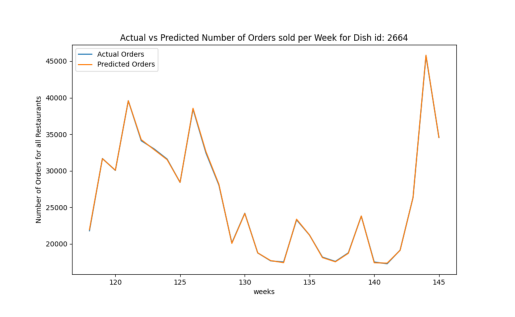

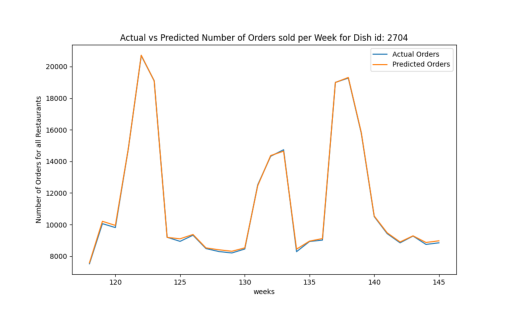

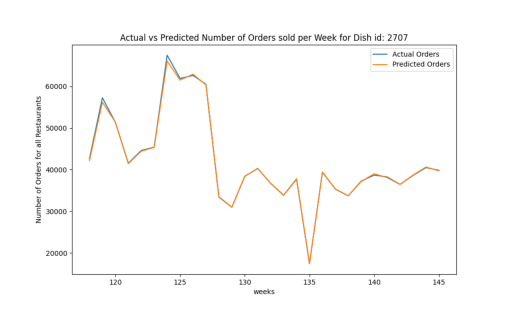

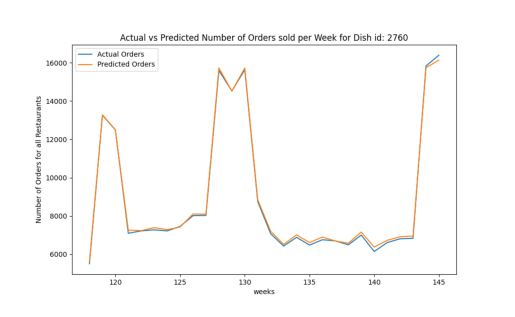

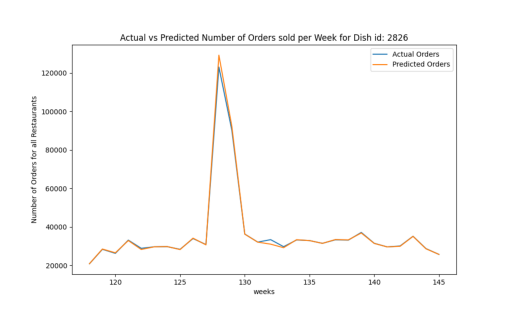

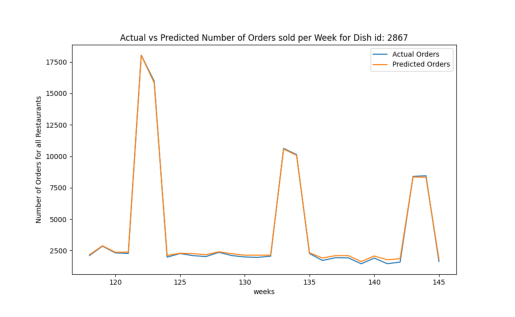

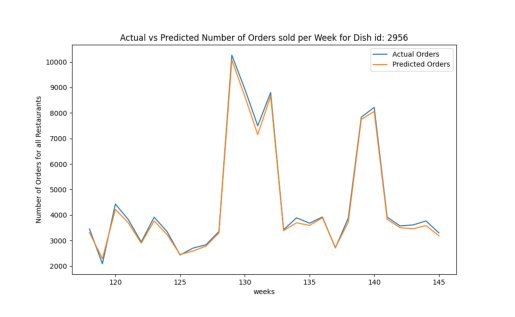


******************************************************

Graph generated using the  GradientBoostingRegressor(max_depth=5, min_samples_leaf=5)


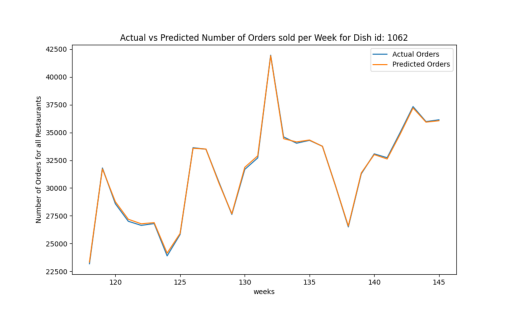

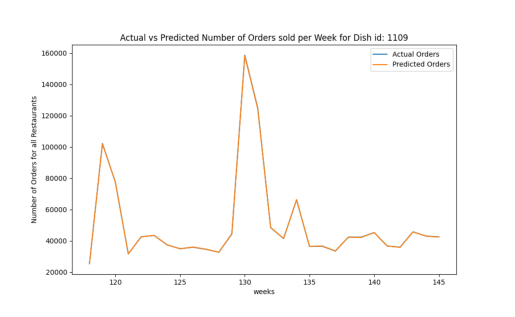

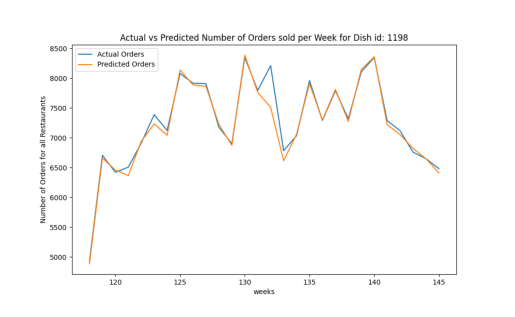

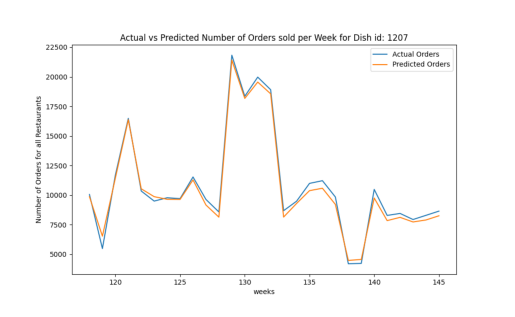

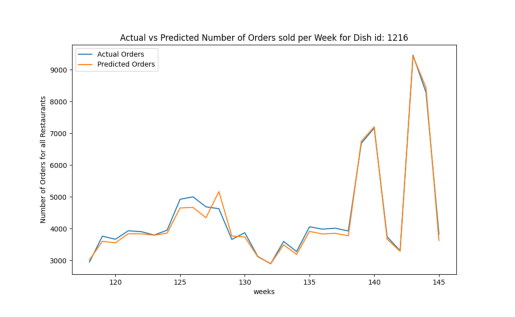

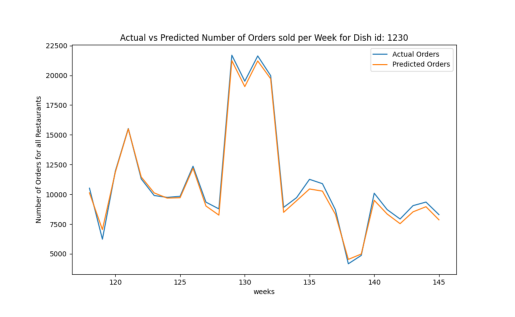

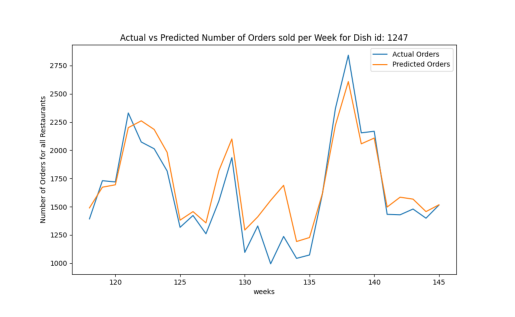

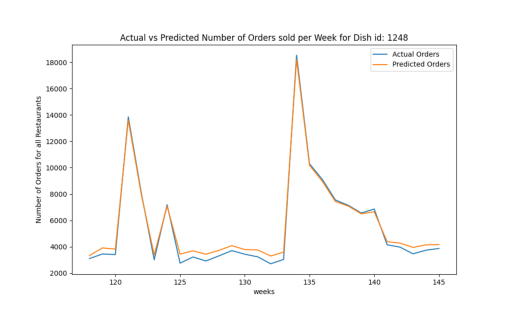

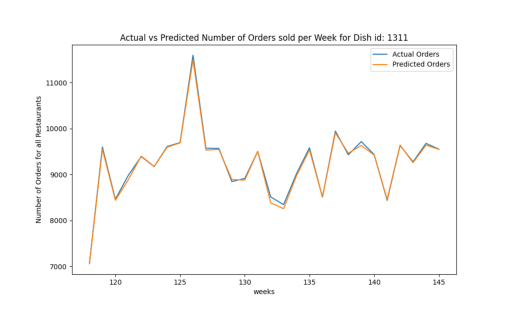

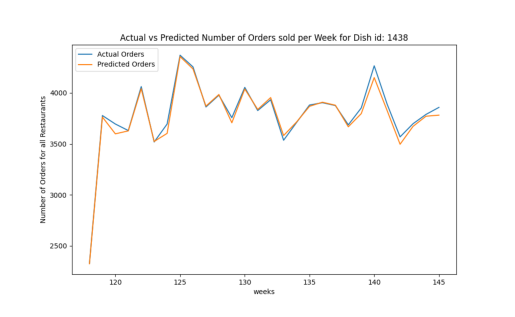

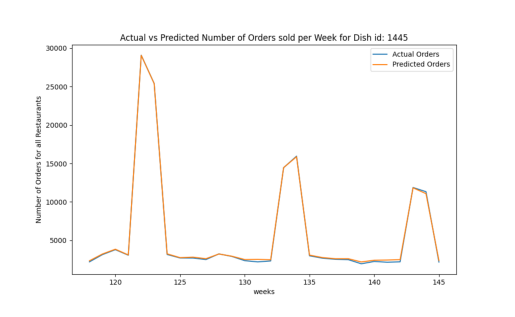

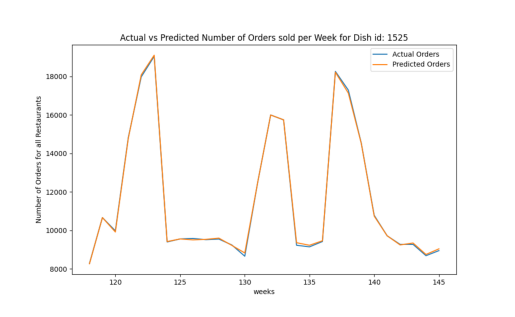

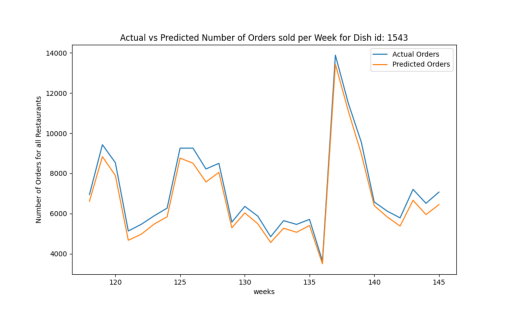

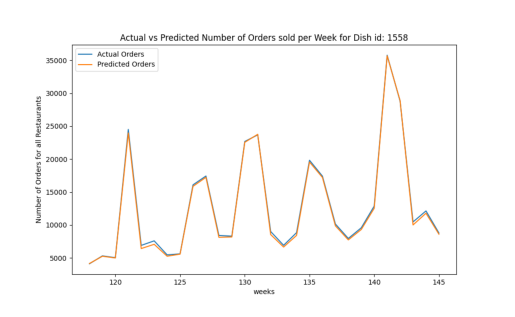

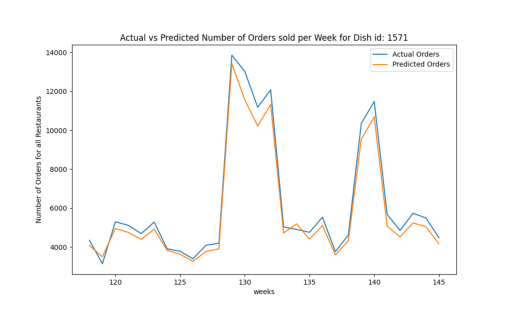

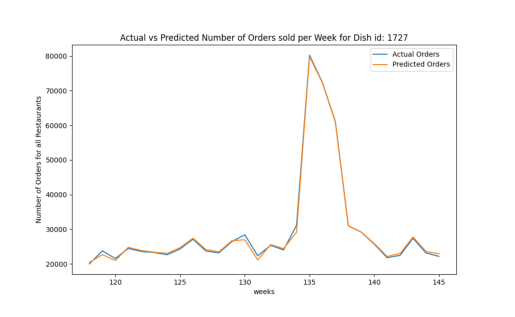

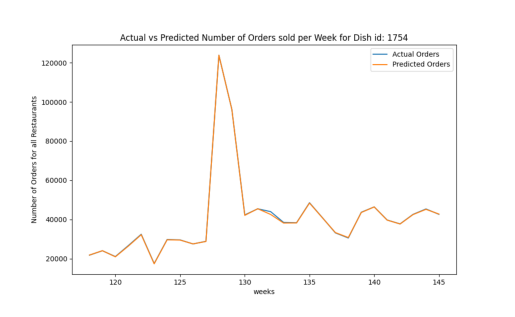

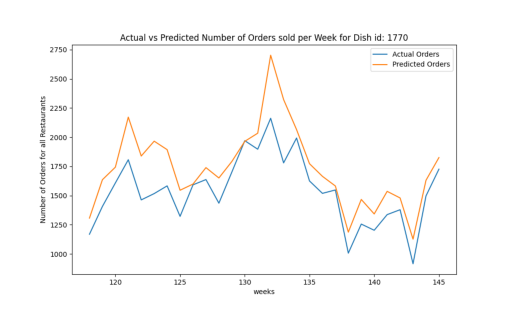

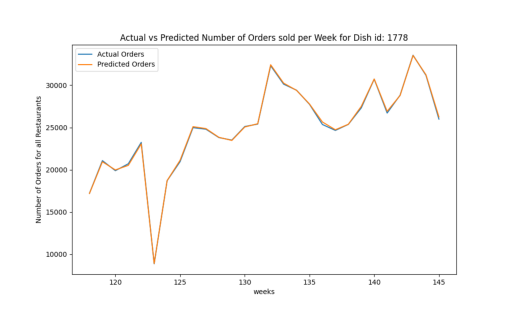

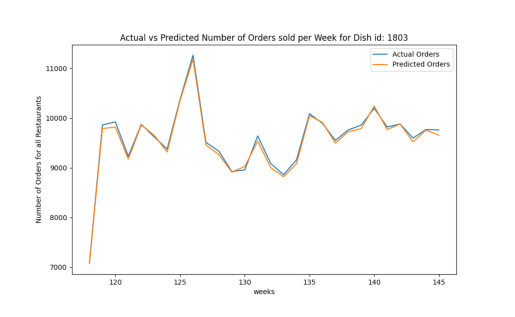

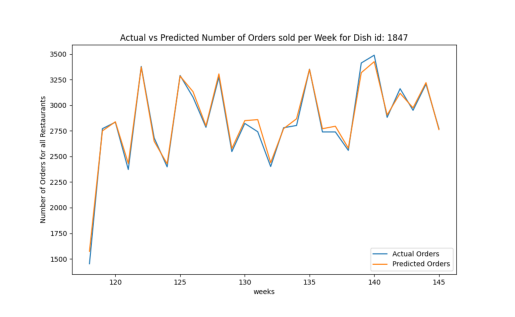

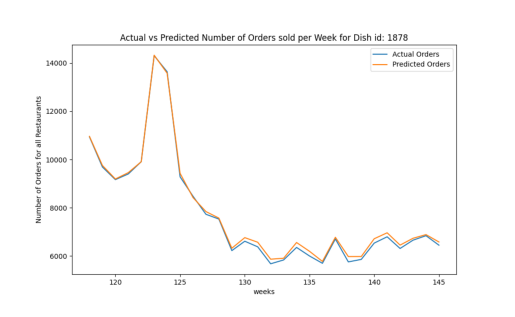

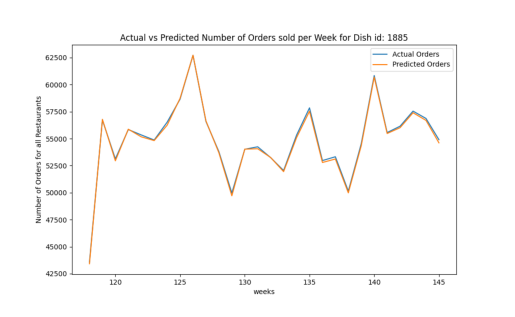

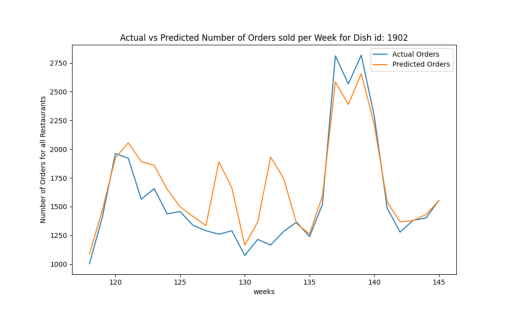

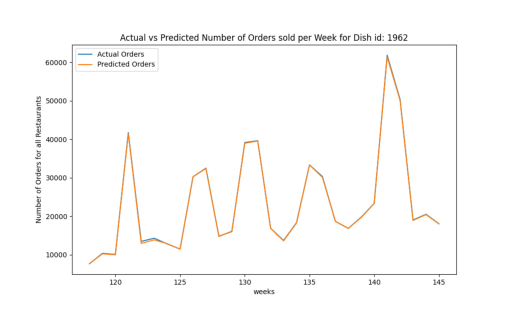

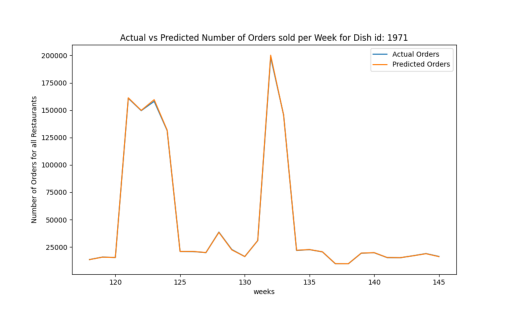

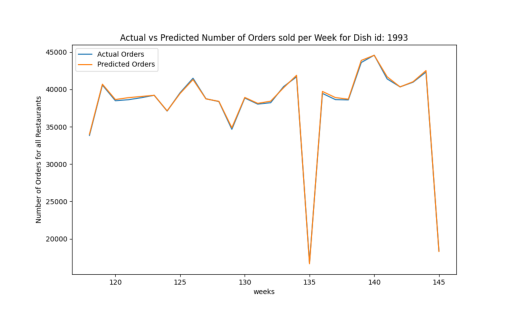

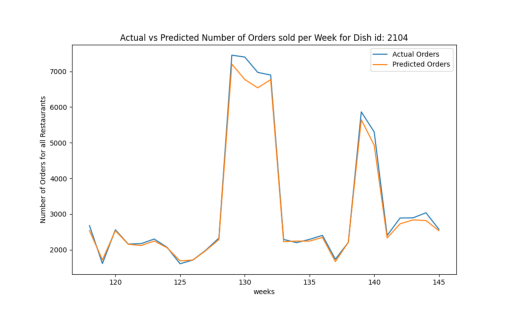

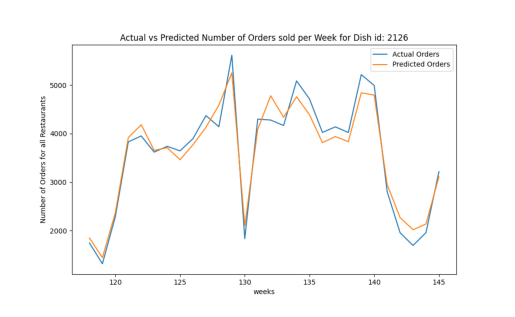

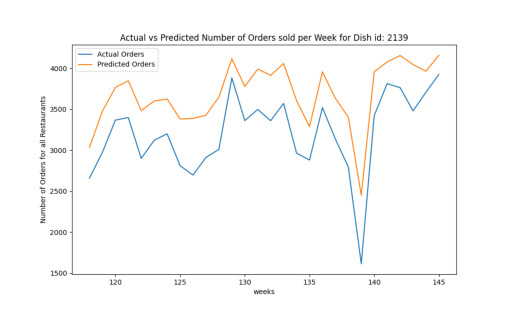

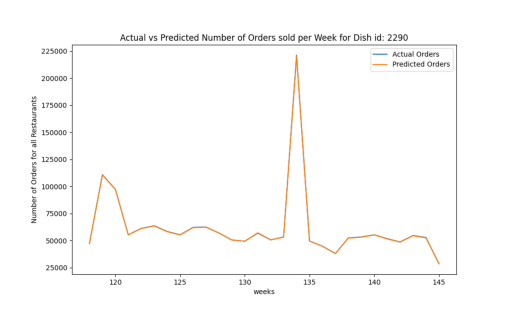

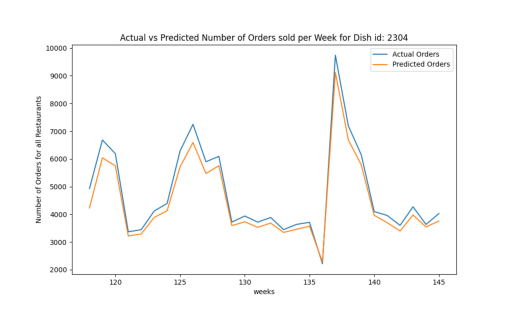

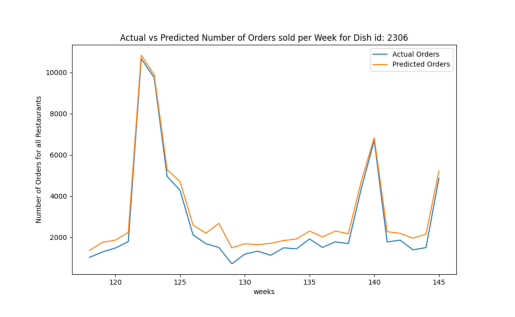

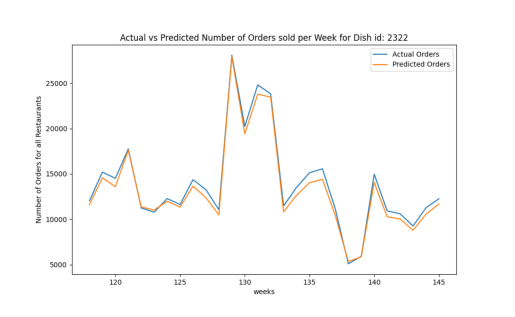

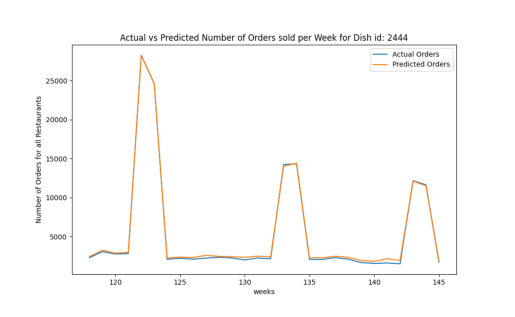

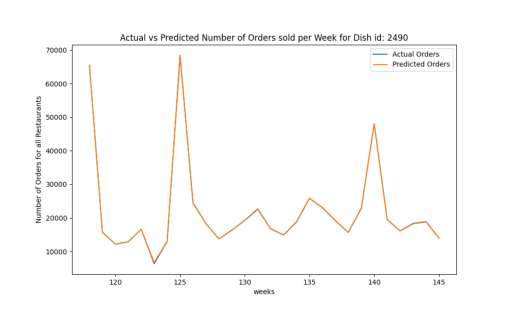

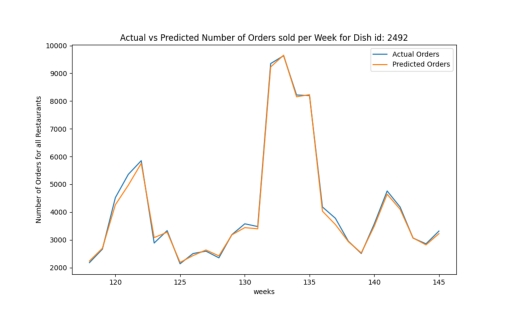

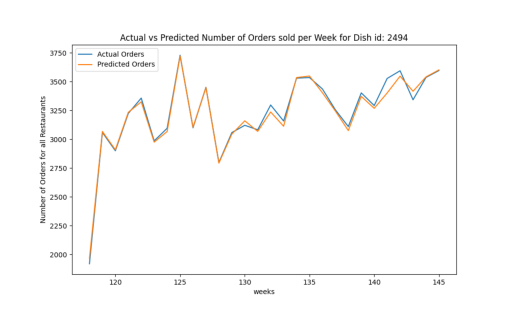

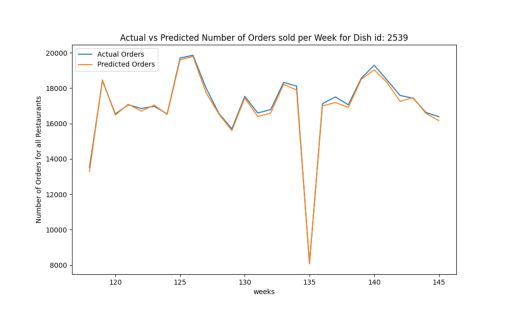

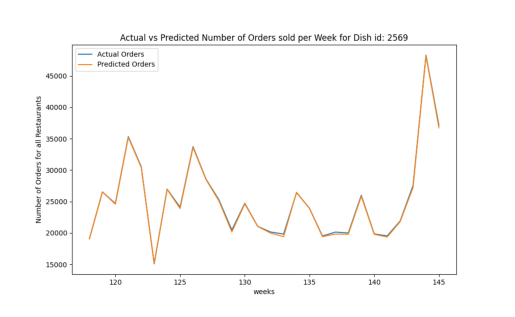

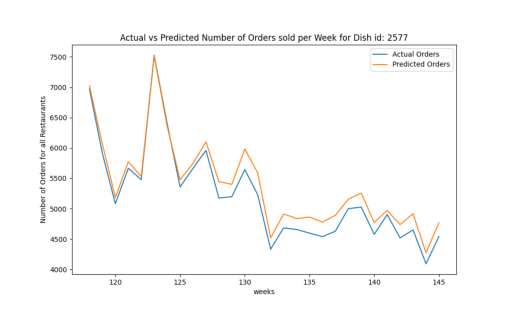

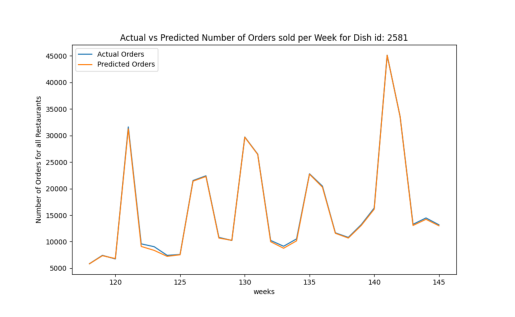

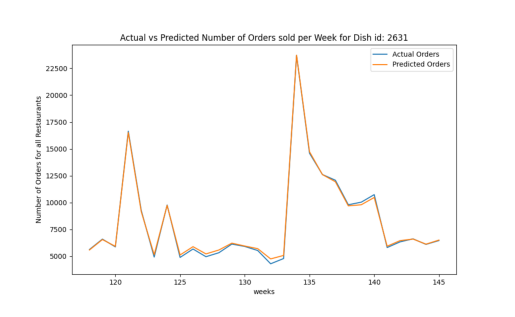

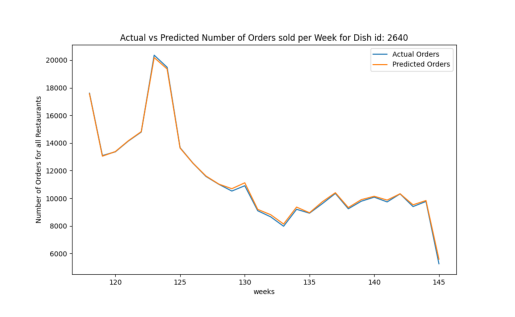

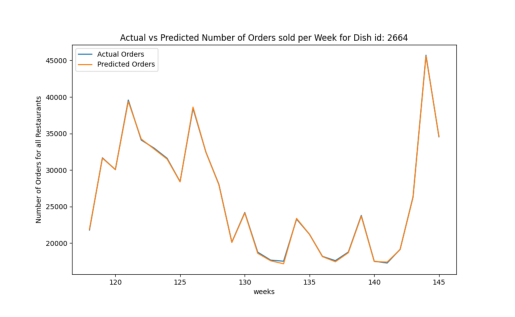

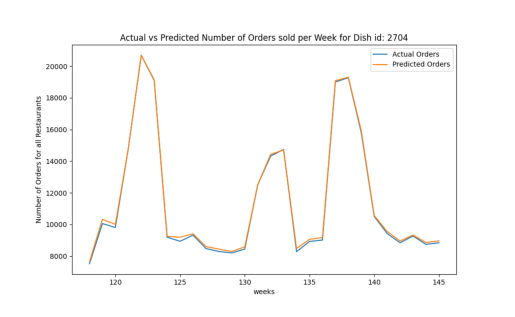

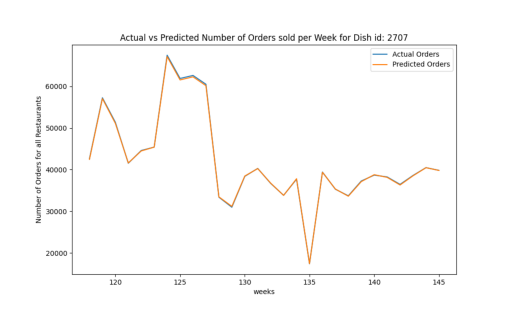

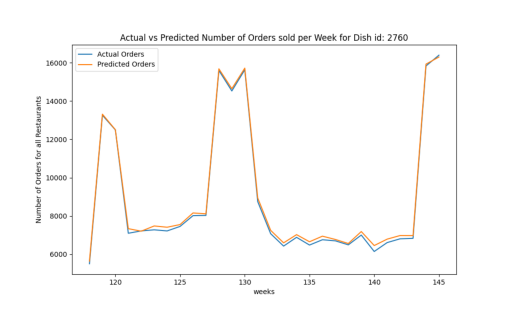

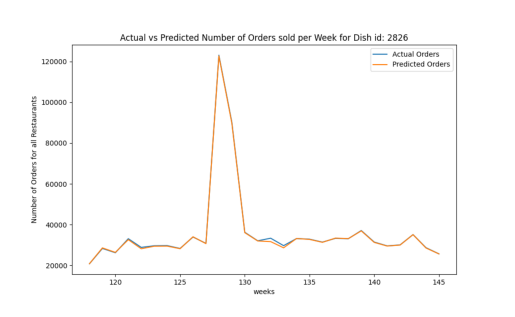

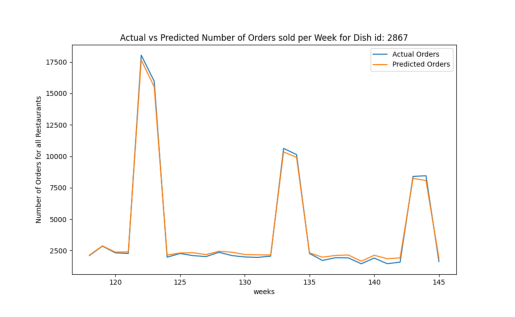

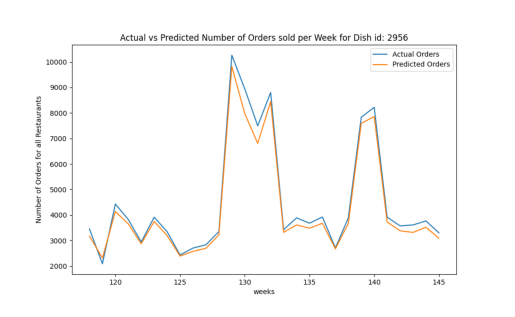


******************************************************

Graph generated using the  RandomForestRegressor(max_depth=5, min_samples_leaf=5)


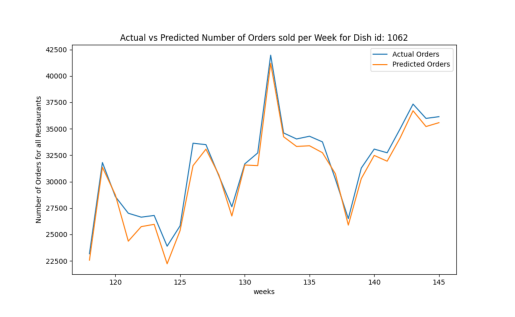

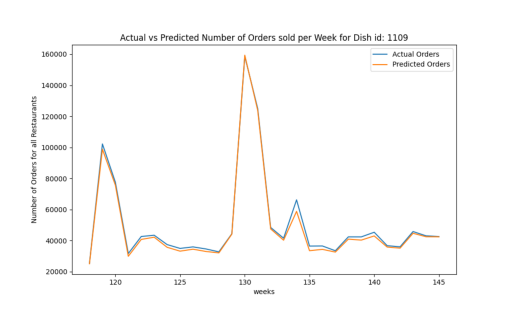

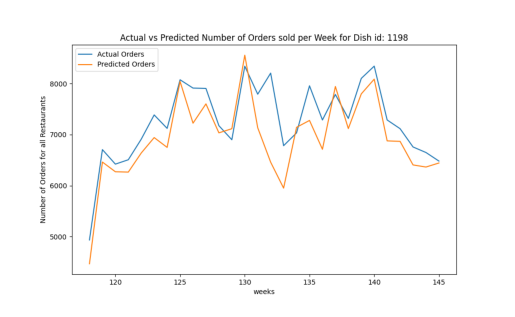

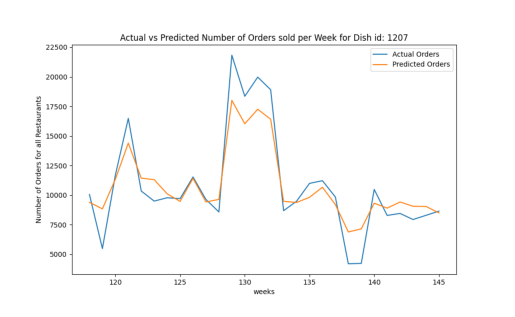

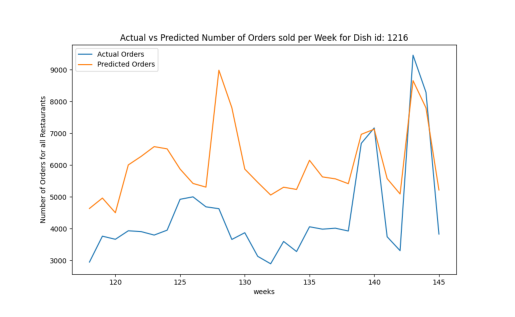

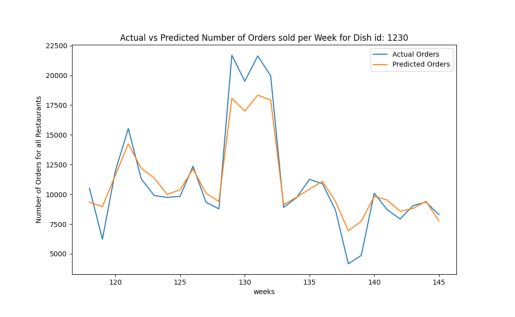

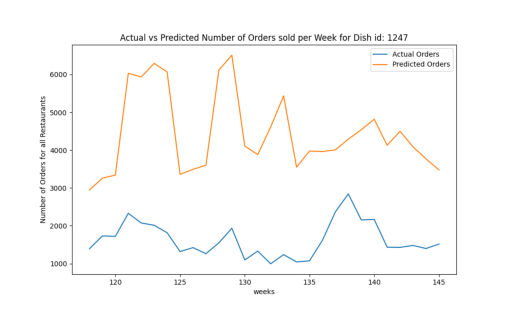

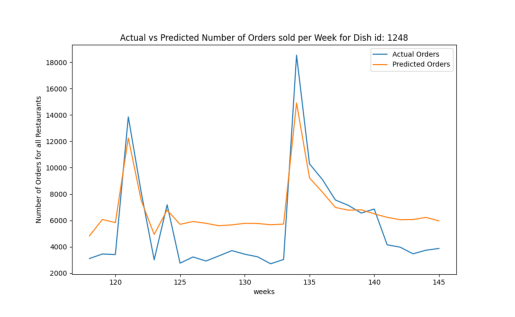

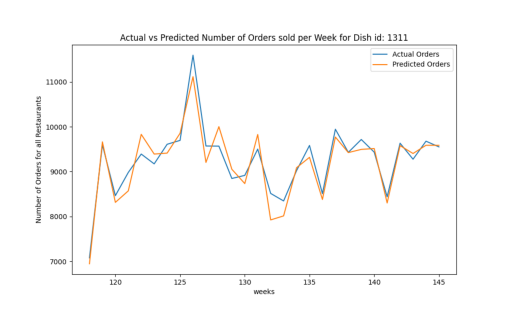

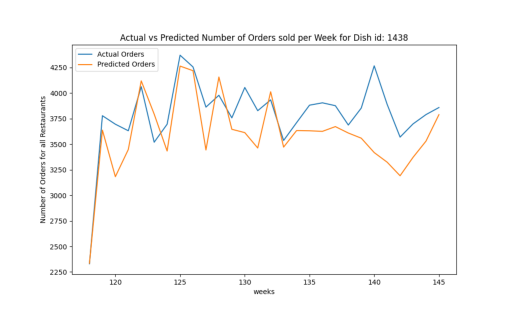

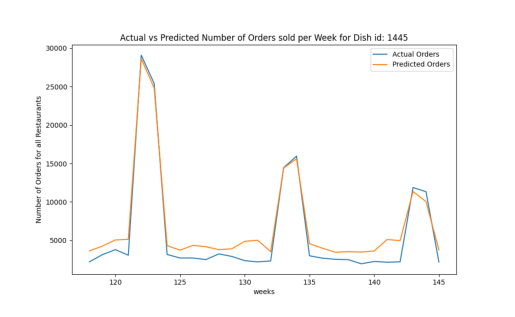

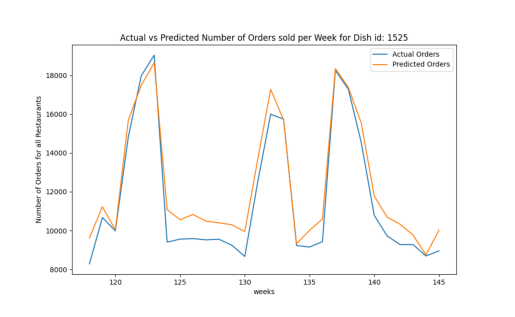

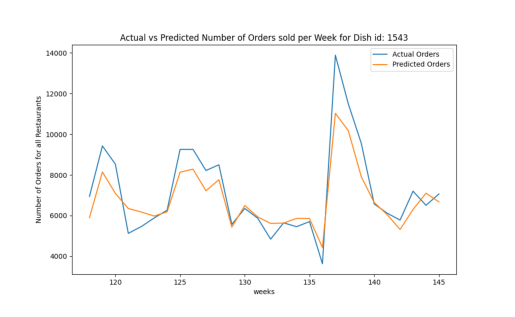

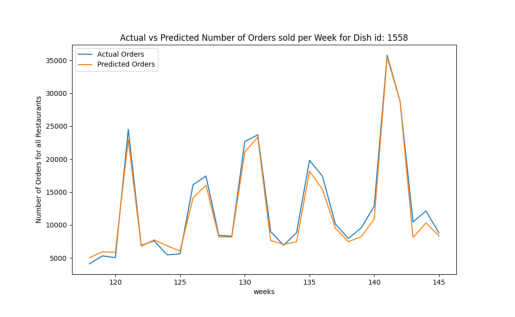

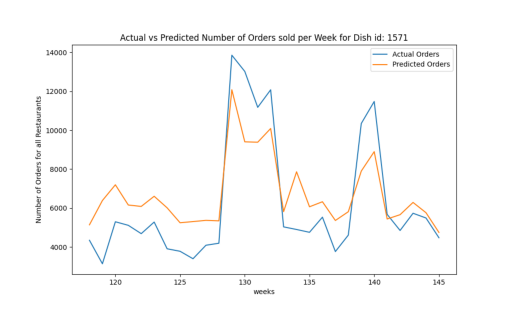

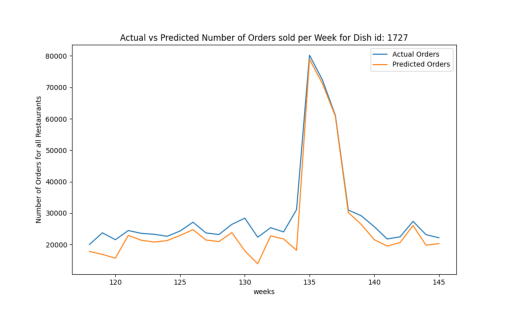

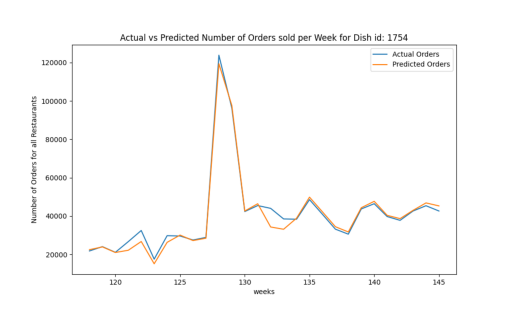

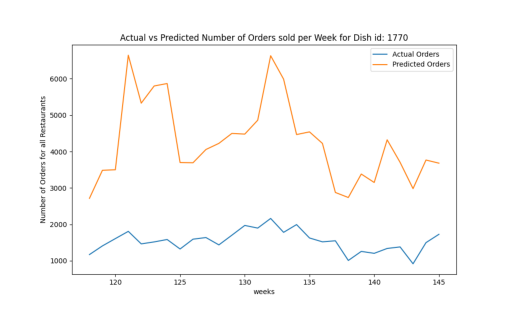

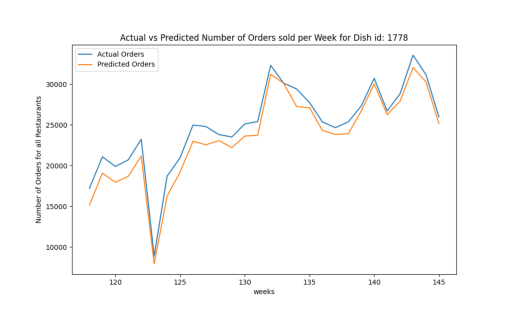

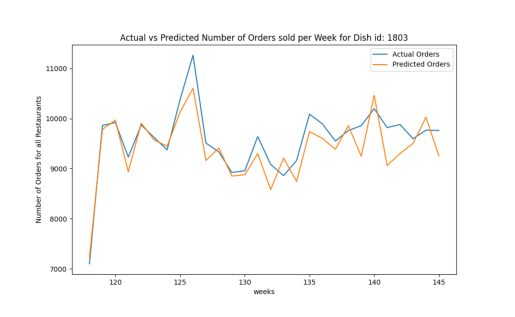

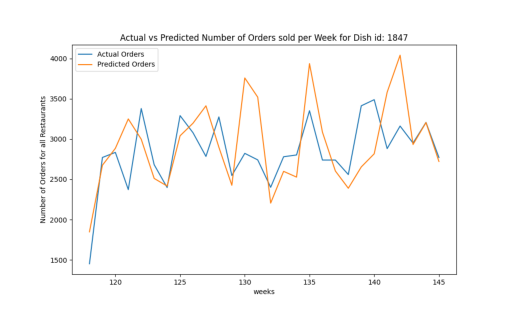

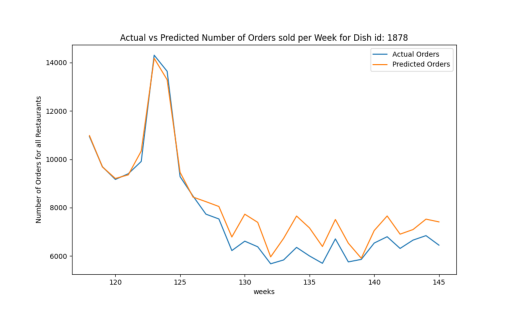

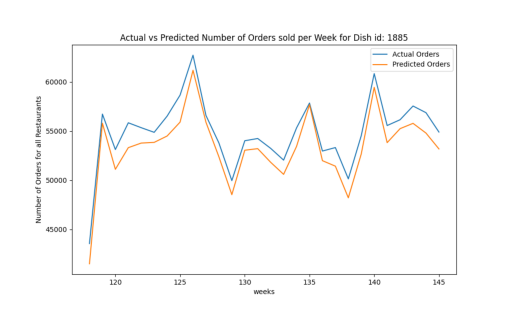

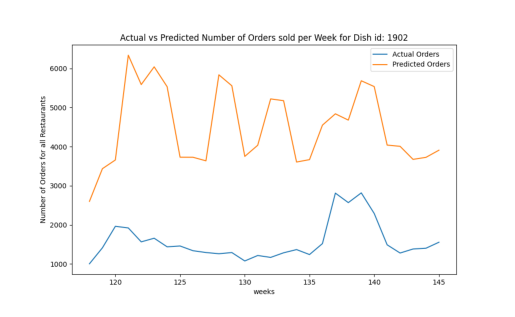

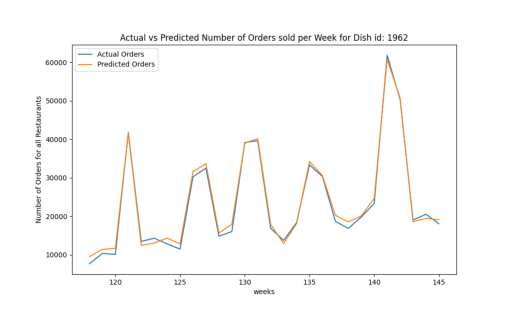

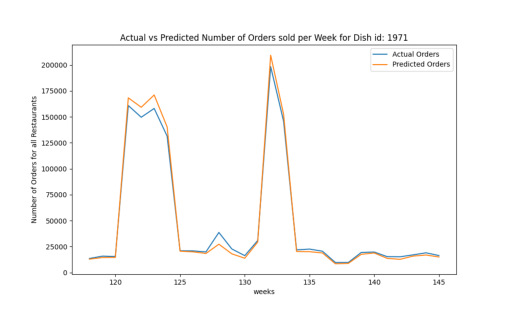

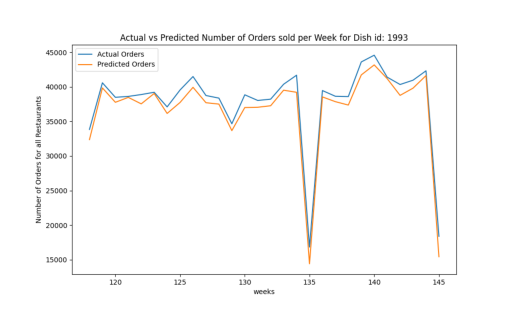

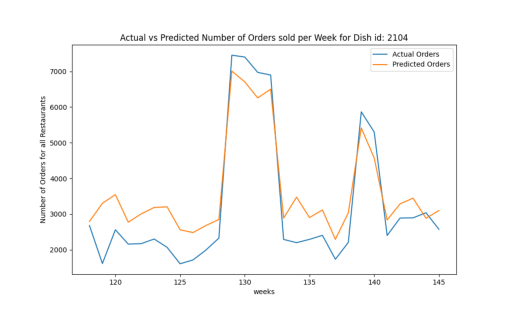

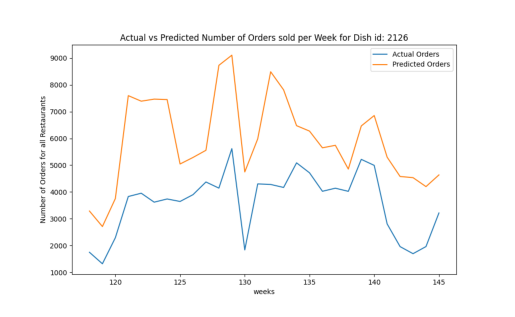

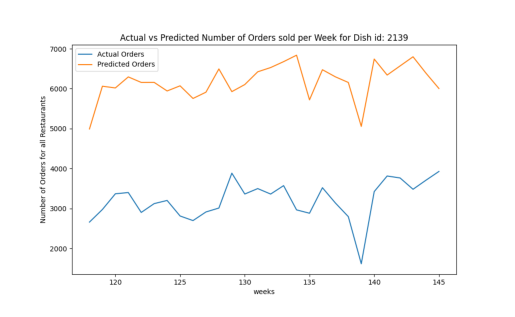

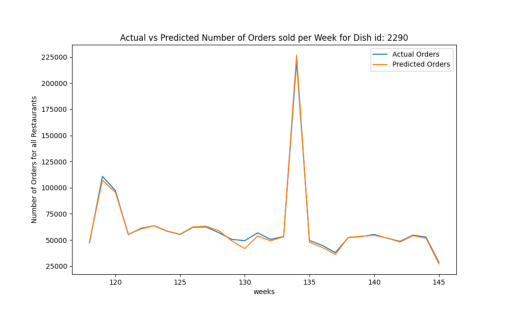

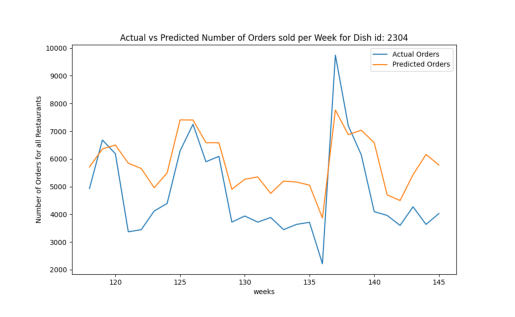

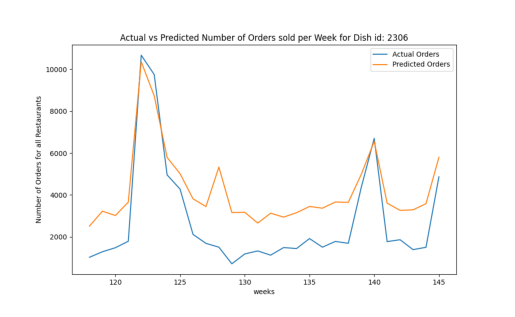

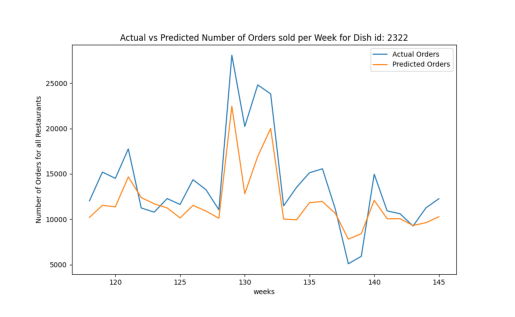

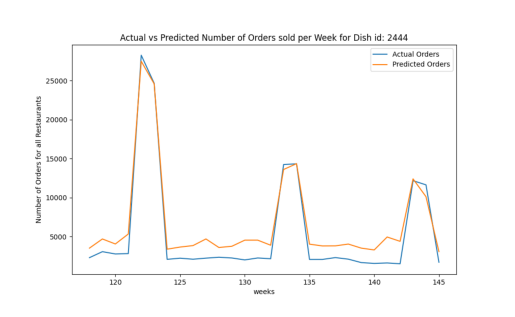

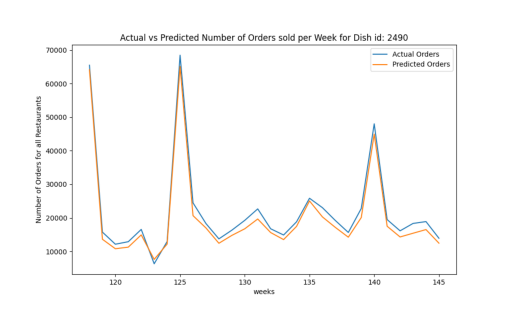

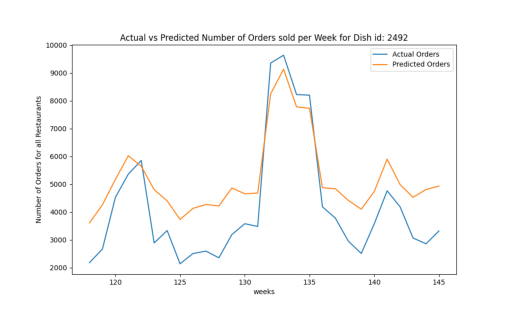

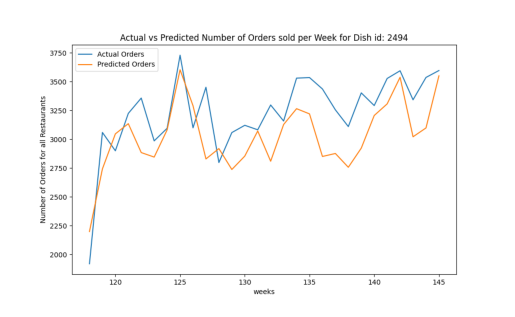

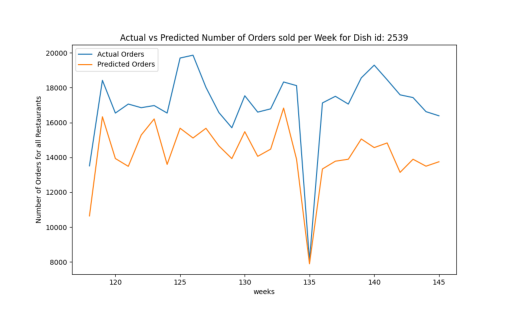

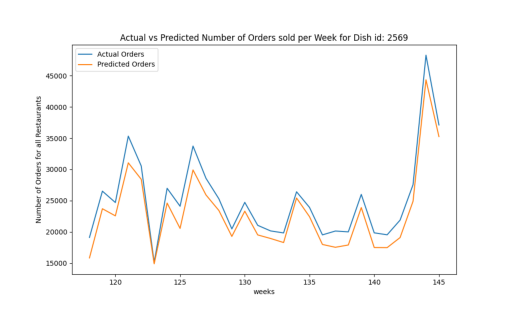

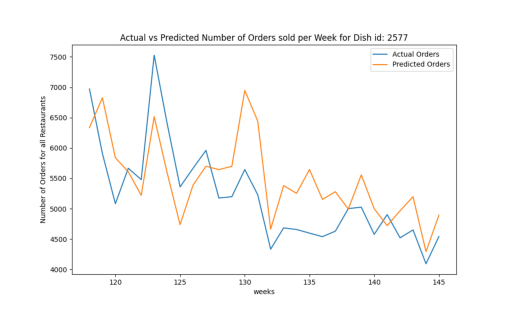

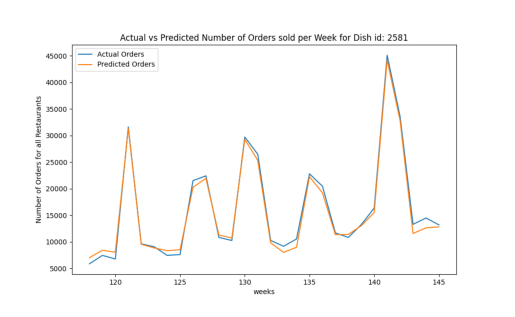

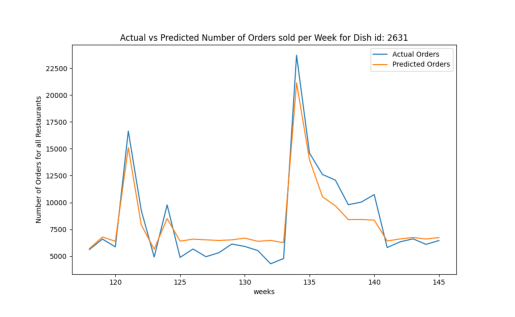

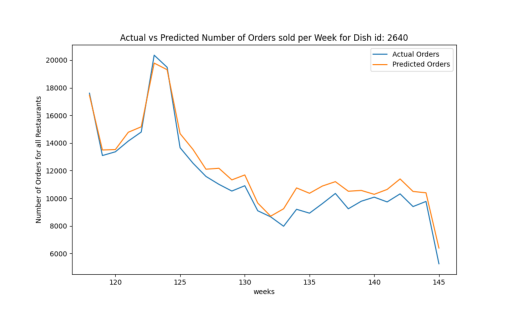

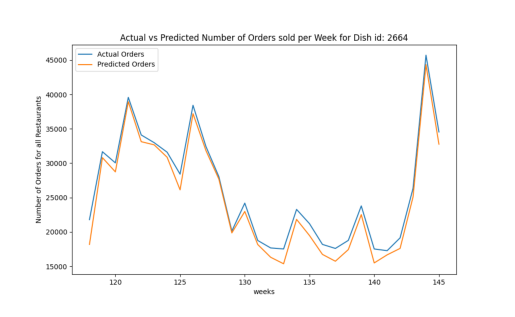

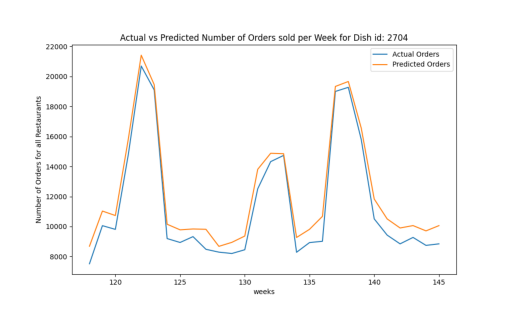

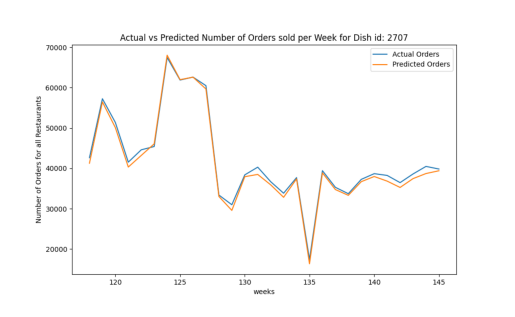

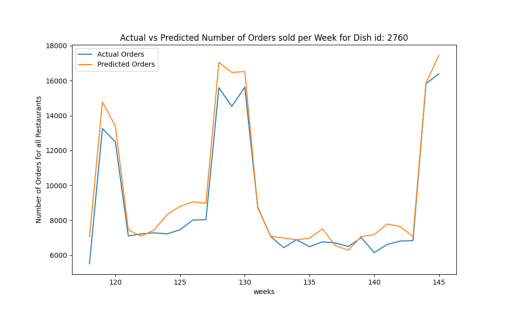

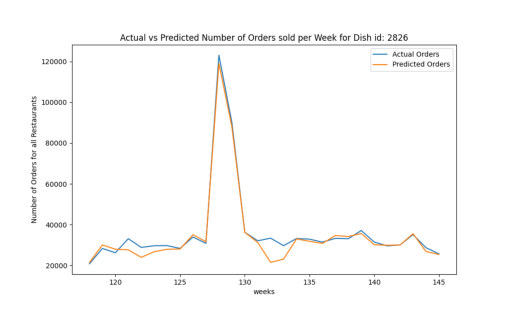

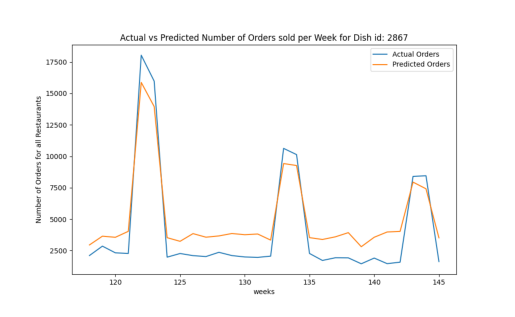

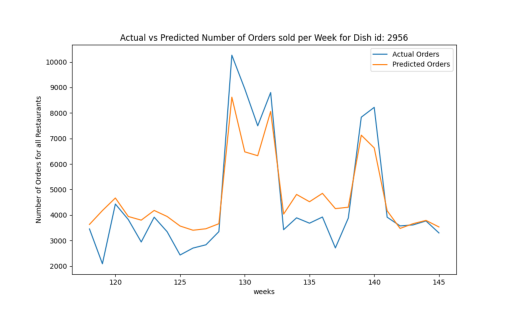


******************************************************



In [54]:
for folder, model in folderList:
    print("Graph generated using the ",model)
    generateAndSaveGraphs(folder, model, X_test=X_test,Y_test=Y_test, dish_id=dish_id)
    print("\n******************************************************\n")

In [55]:
def preprocessModule1(df):
    
    df['Week'] = df['Week'].astype('int64')
    df['Center Id'] = df['Center Id'].astype('int64')
    df['Dish Id'] = df['Dish Id'].astype('int64')
    df['Checkout Price'] = df['Checkout Price'].astype('float64')
    df['Base Price'] = df['Base Price'].astype('float64')
    df['Emailer For Promotion'] = df['Emailer For Promotion'].astype('int64')
    df['Homepage Featured'] = df['Homepage Featured'].astype('int64')

    #Remove unnecessary fields
    if "id" in list(df.columns):
        df = df.drop(['id'], axis=1) 
        
    if "Num Orders" in list(df.columns):
        df = df.drop(["Num Orders"], axis=1) 

    #Merging of dataframes
    df = df.merge(dishDf, left_on='Dish Id', right_on='Dish Id', how= "left")
    df = df.merge(centerDf, left_on='Center Id', right_on='Center Id', how= "left")

    #Encoding the record
    for name, data in encData.items():
        df = df.replace(name,data)

        
    return df

In [56]:
def numOrderPredictor(dat, model):
    numOrder = int(abs(model.predict(dat)))
    return numOrder

In [57]:
def quantityCalculator(dat, numOrder, inventory, ar):
    dId = list(dat["Dish Id"])[0]
    ing = ar[ar["Dish Id"] == dId]

    for i in ing.index:
        d = ar.iloc[ar.index == i]
        q = list(d["Quantity"])[0]
        n = list(d["Ingredient Name"])[0]
        u = list(d["Unit"])[0]
        nu = list(inventory[(inventory["Ingredient Name"] ==  n) & (inventory["Unit"] ==  u)]["Quantity"])[0]
        inventory[(inventory["Ingredient Name"] ==  n) & (inventory["Unit"] ==  u)] = inventory[(inventory["Ingredient Name"] ==  n) & (inventory["Unit"] ==  u)].replace(nu, nu + q*numOrder)

In [58]:
def quantityConverter(inventory,vm,rb):
    ind = 0
    for i in vm.index:
        dat = vm.iloc[rb.index == i]
        eq = list(dat["Equivalent Quantity"])[0]
        n = list(dat["Ingredient Name"])[0]
        u = list(dat["Unit"])[0]
        q = inventory._get_value(ind,'Quantity')
        ind += 1
        rb[(rb["Ingredient Name"] ==  n) & (rb["Unit"] ==  u)] = rb[(rb["Ingredient Name"] ==  n) & (rb["Unit"] ==  u)].replace(1, eq*q)
    rb = rb.drop(["Equivalent Quantity", "Unit"], axis = 1)
    rawMaterial = rb.groupby(['Ingredient Name', "C_unit"])['Quantity'].sum()
    rawMaterial = rawMaterial.to_frame()
    return rb

In [59]:
def rawMaterialQuantityIdentifier(dum, model):
    
    ar = pd.read_csv(r"..\Database\allRecipe.csv")
    ar = ar.sort_values(by = "Ingredient Name")
    vm = pd.read_csv(r"..\Database\vMeasurement.csv")
    inventory =  pd.read_csv(r"..\Database\inventory.csv")
    rb = vm
    
    dummy = dum
    dummy = preprocessModule1(dummy)
    dummy = preprocessSTL(dummy)
    
    for i in dummy.index:
        numOrder = numOrderPredictor(dummy.iloc[dummy.index == i], model)
        quantityCalculator(dummy.iloc[dummy.index == i], numOrder, inventory, ar)
    rawMaterial = quantityConverter(inventory, vm, rb)
        
    return rawMaterial[rawMaterial["Quantity"] != 0]

In [60]:
def inputData(df, model):
    
    data = rawMaterialQuantityIdentifier(df, model) 
    return data

In [61]:
saleDf = pd.read_csv(r"..\DataSet\Dish Sales dataset\sales_info.csv")
tempData = saleDf.sample()
tempData

id  Week  Center Id  Dish Id  Checkout Price  Base Price   
183858  1283070    62        149     1525          273.54      273.54  \

        Emailer For Promotion  Homepage Featured  Num Orders  
183858                      0                  0          27

In [62]:
M = inputData(tempData,getModel('hist_gradient_boosting'))
M

Ingredient Name  Quantity C_unit
20      breadcrumb   6075.00      g
24          butter    776.79      g
31          cheese   6390.90      g
59             egg     54.00  piece
97    onion powder    197.10      g

# Simple Web Application

In [ ]:
app = Flask(__name__)
app.config['SECRET_KEY'] = 'mysecretkey'

df_inputs = pd.DataFrame(columns=['Week',
                                  'Center Id',
                                  'Dish Id',
                                  'Checkout Price',
                                  'Base Price',
                                  'Emailer For Promotion',
                                  'Homepage Featured'])

df_output = pd.DataFrame(columns=['Ingredient Name', 'Quantity', 'C_unit'])

@app.route('/', methods=['GET', 'POST'])
def index():
    global df_output
    global df_inputs
    
    model_name = 'hist_gradient_boosting'
    empty_fields = {}
    show_loader = False
    
    if request.method == 'POST':
        if 'addItem' in request.form:
            week = request.form['week']
            centerId = request.form['center_id']
            dishId = request.form['dish_id']
            checkoutPrice = request.form['checkout_price']
            basePrice = request.form['base_price']
            emailerForPromotion = request.form['email_for_promotion']
            homepageFeatured = request.form['homepage_featured']
            
            empty_fields = {}
            mod = {}
            if not week:
                empty_fields['week'] = True
            if not centerId:
                empty_fields['center_id'] = True
            if not dishId:
                empty_fields['dish_id'] = True
            if not checkoutPrice:
                empty_fields['checkout_price'] = True
            if not basePrice:
                empty_fields['base_price'] = True
            if not emailerForPromotion:
                empty_fields['email_for_promotion'] = True
            if not homepageFeatured:
                empty_fields['homepage_featured'] = True
            
            if not empty_fields:
                df_inputs.loc[len(df_inputs)] = [week,
                                                 centerId,
                                                 dishId,
                                                 checkoutPrice,
                                                 basePrice,
                                                 emailerForPromotion,
                                                 homepageFeatured]
        
        elif 'deleteItem' in request.form:
            index = int(request.form['deleteItem'])
            if 0 <= index < len(df_inputs):
                df_inputs = df_inputs.drop(index)
                
        elif 'submit' in request.form:

            
            if len(df_inputs) != 0:
            
                model = getModel(model_name)
                
                if model is not None:
                    df_output = inputData(df_inputs, model)
                
                else:
                    print("Model is none")
                
                
                
                
    else:
        empty_fields = {}
    
    dropdown_options_center_id = center_id 
    dropdown_options_dish_id = dish_id 
   
    return render_template('index.html',
                           empty_fields=empty_fields,
                           dropdown_options_center_id=dropdown_options_center_id,
                           dropdown_options_dish_id=dropdown_options_dish_id,
                           df_inputs=df_inputs.iterrows(),
                           df_output=df_output.to_dict('records'),
                           show_loader=show_loader)


if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [21/Jun/2023 17:01:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jun/2023 17:01:07] "GET /static/main.css HTTP/1.1" 200 -
127.0.0.1 - - [21/Jun/2023 17:01:07] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [21/Jun/2023 17:01:25] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jun/2023 17:01:25] "GET /static/main.css HTTP/1.1" 304 -
127.0.0.1 - - [21/Jun/2023 17:02:50] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jun/2023 17:02:51] "GET /static/main.css HTTP/1.1" 304 -
127.0.0.1 - - [21/Jun/2023 17:03:20] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jun/2023 17:03:20] "GET /static/main.css HTTP/1.1" 304 -
127.0.0.1 - - [21/Jun/2023 17:03:47] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jun/2023 17:03:47] "GET /static/main.css HTTP/1.1" 304 -
127.0.0.1 - - [21/Jun/2023 17:04:26] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jun/2023 17:04:26] "GET /static/main.css HTTP/1.1" 304 -
127.0.0.1 - - [21/Jun/2023 17:06:51] "POST / HTTP/1.1" 20